In [18]:
#imports
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib
#necessary for plotly interactivity. dont ask me why
matplotlib.use('nbagg')
import numpy as np
import scipy as sp 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#from scipy import special
from random import gauss
#import hdf5storage
import h5py
import timeit
#from numba import jit
#from sympy.solvers.solveset import nonlinsolve
#from sympy.core.symbol import symbols
#from sympy import exp
from scipy import stats, io, sparse
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from core.analysis import *
from core.simulation import *
import similaritymeasures as sm
sp.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'1.7.0'

# fibers and mesh construction

In [ ]:
#(if needed) construct some necessary properties from the 'Fibers' matlab data
#note that the function is set to utilize the data in 'fgCC', following selen's instruction
#however, another fiber dataset is present inside 'Fibers', called 'fg'.
#the other dataset can be selected manually from inside the function
construct_fibers_from_data(
                #data from Selen Atasoy
                filepath_data='/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/100307_Laplace.mat',
                filepath_Fibers='/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/Fibers_myfix.npy',
                           
                savefiles=True,
                bundle_size=1,
                output_filepath_fiber_edges='/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/fgCCfix_fiber_edges.npy',
                output_filepath_fiber_lengths='/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/fgCCfix_fiber_lengths.npy',                       
                output_filepath_fiber_dist_starts='/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/fgCCfix_fiber_dist_starts.npy',
                output_filepath_fiber_dist_ends='/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/fgCCfix_fiber_dist_ends.npy',
                output_filepath_fiber_ends='/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/fgCCfix_fiber_ends.npy')    

In [3]:
#(if needed) construct the mesh + DTI adjacency directly from the 'faces' and 'fibers' datasets
#the subcortical nodes and edges are excluded at the end of the procedure
#if the 'visual' option is selected, the function also returns datasets in suitable format for plotly
mesh_DTI_adjacency, Xn, Yn, Zn, iN, jN, kN,  Xe, Ye, Ze = construct_adjacency_matrix_from_data(
                                #data from Selen Atasoy
                                filepath_data='/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/100307_Laplace.mat',
                                
                                #results of previous cell
                                filepath_fiber_edges=['/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/fgCCfix_fiber_edges.npy'],#,'/Volumes/Seagate Expansion Drive/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_edges.npy'],
                                filepath_fiber_lengths=['/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/fgCCfix_fiber_lengths.npy'],#,'/Volumes/Seagate Expansion Drive/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_lengths.npy'],
                                filepath_fiber_ends=['/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/fgCCfix_fiber_ends.npy'],#,'/Volumes/Seagate Expansion Drive/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_ends.npy'],
                                
                                include_subcortex=False,
                                add_DTI=True,
                                fiber_speed_factor=200,
    
                                threshold=False,
                                max_dist=10,
                                filepath_fiber_dist_starts=['/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/fgCCfix_fiber_dist_starts.npy'],#,'/Volumes/Seagate Expansion Drive/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_dist_starts.npy'],
                                filepath_fiber_dist_ends=['/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/fgCCfix_fiber_dist_ends.npy'],#,'/Volumes/Seagate Expansion Drive/Macbook Stuff/Downloads/NeuralFieldModelv2/fg_fiber_dist_ends.npy'],

                                visual=False,
                                plot_subcortex=False,
                                plot_DTI_edges=False)

Constructing mesh adjacency matrix...
Now adding DTI fibers from /Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/fgCCfix_fiber_edges.npy...


In [4]:
#(if needed) construct graph Laplacian from mesh data and diagonalize it
binary = False
#this is the same procedure used for regular graphs
AdjMatrix=mesh_DTI_adjacency.toarray()
#convert mm^2 to m^2
if binary:
    AdjMatrix[AdjMatrix>0] = 1
else:
    #convert mm^2 to m^2
    AdjMatrix*=1000000
    
Deg=np.sum(AdjMatrix, axis=0)
Degree_Matrix=sp.sparse.diags(Deg)
regLap = Degree_Matrix - sp.sparse.csc_matrix(AdjMatrix)
Laplacian=-regLap.toarray()

vecs=True

if vecs==False:    
    eigenvalues=np.linalg.eigvalsh(Laplacian)
    eigenvalues[-1]=0
    eigenvalues=eigenvalues[::-1]
    #np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_full_200short.npy', eigenvalues)
else:
    eigenvalues,eigenvectors=np.linalg.eigh(Laplacian)
    #eigenvalues[-1]=0
    #note that the eigenvectors come out 2-normalized
    eigenvalues=eigenvalues[::-1]
    eigenvectors=eigenvectors[:,::-1]
    #np.save('/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/eigvals_DTI_fgCCfix_200short_metres.npy', eigenvalues)
    #np.save('/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/eigvecs_DTI_fgCCfix_200short_metres.npy', eigenvectors)


<IPython.core.display.Javascript object>


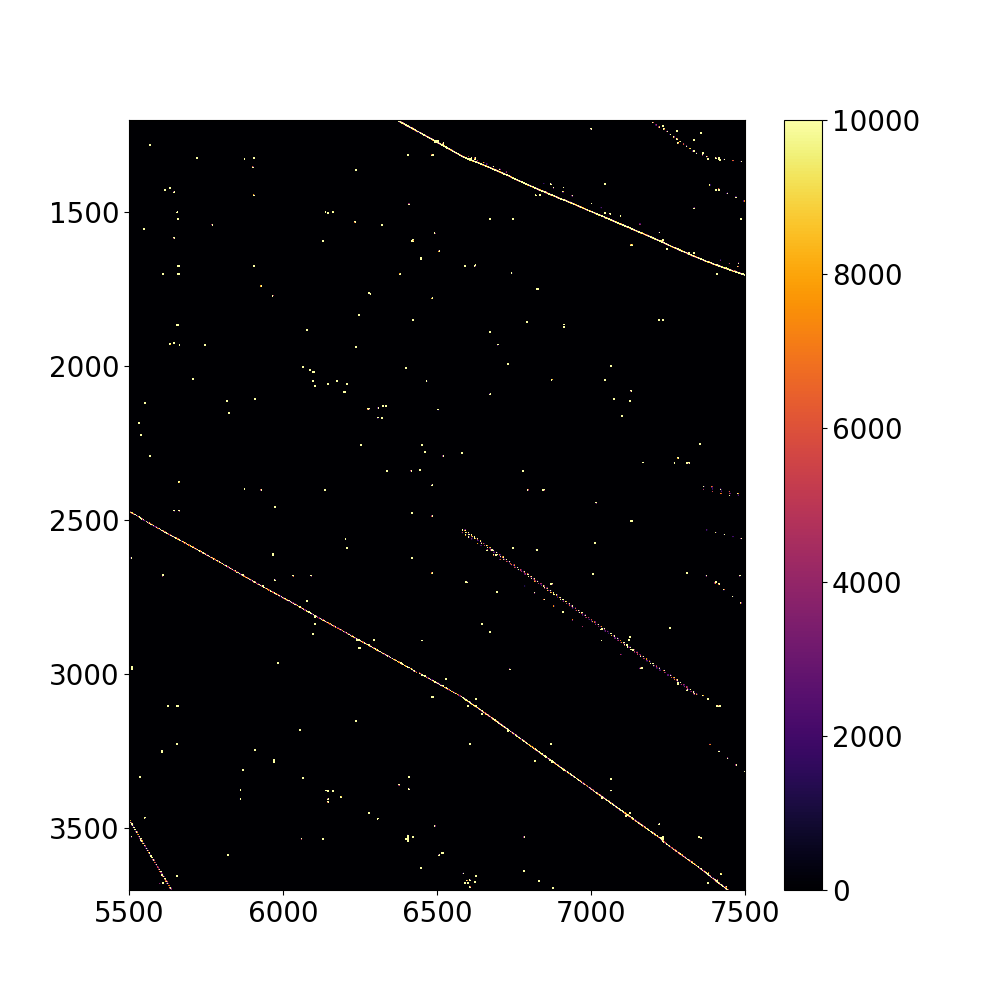

In [23]:
plt.close('all')
plt.figure(figsize=(10,10))
plt.ylim(3700,1200)
plt.xlim(5500,7500)
#plt.ylim(10000,9000)
#plt.xlim(11000,12000)
plt.imshow(AdjMatrix, vmin=0, vmax=1e4, cmap='inferno')

plt.colorbar()

# init from data

In [3]:
#len(np.nonzero(mesh_DTI_adjacency.toarray())[0])/2
#np.shape(mesh_DTI_adjacency.toarray())
f = h5py.File('/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/100307_Laplace.mat', 'r')
CC = np.asarray(f['CC']['restInds'], dtype=int)
indices = np.array([elem[0] for elem in CC])-1
AllVet=np.asarray(f['vertices']['all'])

#u_0=np.heaviside(AllVet[0,indices],0)
f.close()
#no_sub=mesh_DTI_adjacency[indices,:]
#no_sub=no_sub[:,indices]
#len(np.nonzero(no_sub.toarray())[0])/2
#mesh_DTI_adjacency=np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/metric_cortical_DTI_bundles_full_all_fibers.npy')
#mesh_DTI_adjacency=mesh_DTI_adjacency[indices,:]
#mesh_DTI_adjacency=mesh_DTI_adjacency[:,indices]
#mesh_DTI_adjacency.toarray().shape

In [4]:
##np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/metric_cortical_DTI_bundles_full_all_fibers.npy', mesh_DTI_adjacency)

In [4]:

#Alternatively, if previously known, read eigenvalues and eigenvectors from file
#this is what i used for the thesis. note that it has to be loaded with a minus sign
#eigenvalues_thesis = -np.load('E:/My Documents/Dropbox/Amsterdam Math/Rikkert Hindriks/Graph-Stochastic-Wilson-Cowan-Model/data/eigvals.npy')
#this should be the corresponding eigenvectors. they appear to be 1-normalized
#eigenvectors_thesis = -np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvecs.npy')

#eigenvalues = np.load('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_fgCC_200short.npy')
#eigenvalues = np.load('/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/eigvals_DTI_fgCC_200short_metres.npy')
#eigenvectors = np.load('/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/eigvecs_DTI_fgCC_200short_metres.npy')

eigenvalues = np.load('/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/eigvals_DTI_fgCCfix_200short_metres.npy')
eigenvectors = np.load('/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/eigvecs_DTI_fgCCfix_200short_metres.npy')

#eigenvalues = -np.load('E:/My Documents/Dropbox/Amsterdam Math/Rikkert Hindriks/Graph-Stochastic-Wilson-Cowan-Model/data/eigvals.npy')
len(eigenvalues)
#np.save('G:/Macbook Stuff/Downloads/NeuralFieldModelv2/eigvals_DTI_fgCC_200short_metres.npy', eigenvalues)
#print(eigenvalues)
#print(eigenvalues2)

18715

In [5]:
Graph_Kernel='Gaussian'

#thesis values
first_k=2
last_k=5000
thesis_spatial_spectrum = 15*(np.arange(first_k,last_k)**(-0.3))

#post-thesis work
first_k=3
last_k=len(eigenvalues)
x_t = np.log(np.arange(first_k,last_k))
new_spatial_spectrum = 10**(-0.012*x_t**(2.2) + 0.6 + 0.5*x_t**(-0.3))#0.02*x_t**(1.1)+1.1)# + x_t**(-1.5)+10)
#more similar to fluctuations power data from selen
new_spatial_spectrum = 10**(-0.018*x_t**(2.2) + 0.5 + 0.5*x_t**(-0.3))

#empirical SPS
first_k=1
last_k=15000#len(eigenvalues)
f = sp.io.loadmat('/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/100307_REST1_LR_selenyeo10k.mat')
timecourse = np.nan_to_num(np.concatenate((f['selenyeo10kts_lh'],f['selenyeo10kts_rh']), axis=0)[indices])
#errors = np.nan_to_num(np.concatenate((f['selenyeo10kts_lh_stderr'],f['selenyeo10kts_rh_stderr']), axis=0)[indices])

#the Laplace coefficient of the zero-mean timecourses
coeffs = np.dot(eigenvectors.T,(timecourse-timecourse.mean(1)[...,np.newaxis]))
#the Laplace coefficient of the z-scored timecourses
#coeffs_zscore = np.dot(eigenvectors.T,np.nan_to_num(sp.stats.zscore(timecourse, axis=1)))

#here i define logspace binning
bins = np.unique(np.logspace(np.log10(first_k), np.log10(last_k), num=300, dtype=int))[:-1]
bins_positions = np.array([elem.mean() for elem in np.array_split(np.arange(first_k,last_k), bins)])
def median_binning(data,bins):
    return np.array([np.median(elem) for elem in np.array_split(data, bins)])

In [14]:
#np.save('/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/global_tc.npy',timecourse.mean(0))

# functional connectivity various

In [8]:
emp_ps_fc = (np.abs(coeffs)**2).mean(1)
#emp_ps_fc[15000:] = emp_ps_fc[15000:]
#dem_tc = timecourse-timecourse.mean(1)[...,np.newaxis]
#FC_data = np.nan_to_num(np.corrcoef(dem_tc - dem_tc.mean(0)[np.newaxis,...]))
FC_data = np.nan_to_num(np.corrcoef(timecourse-timecourse.mean(1)[...,np.newaxis]))
#FC_data = np.nan_to_num(np.corrcoef(np.nan_to_num(sp.stats.zscore(timecourse, axis=1))))
#FC_data = Functional_Connectivity(eigenvectors, emp_ps_fc, False)

/Users/marcoaqil/anaconda3/envs/prfpy_2021/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/marcoaqil/anaconda3/envs/prfpy_2021/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [17]:
%%capture
#corrcoef FC
plt.close('all')
plt.figure(figsize=(10,10))
plt.ylim(3700,1200)
plt.xlim(5500,7500)
#plt.ylim(10000,9000)
#plt.xlim(11000,12000)
plt.imshow(FC_data, vmin=0, vmax=0.3, cmap='inferno')
plt.colorbar()
plt.savefig('/Volumes/Crucial X8/NFModel_revision_figures/FC/fMRI_FC_inset1_highdpi_fix.pdf', dpi=600, bbox_inches='tight')

<IPython.core.display.Javascript object>


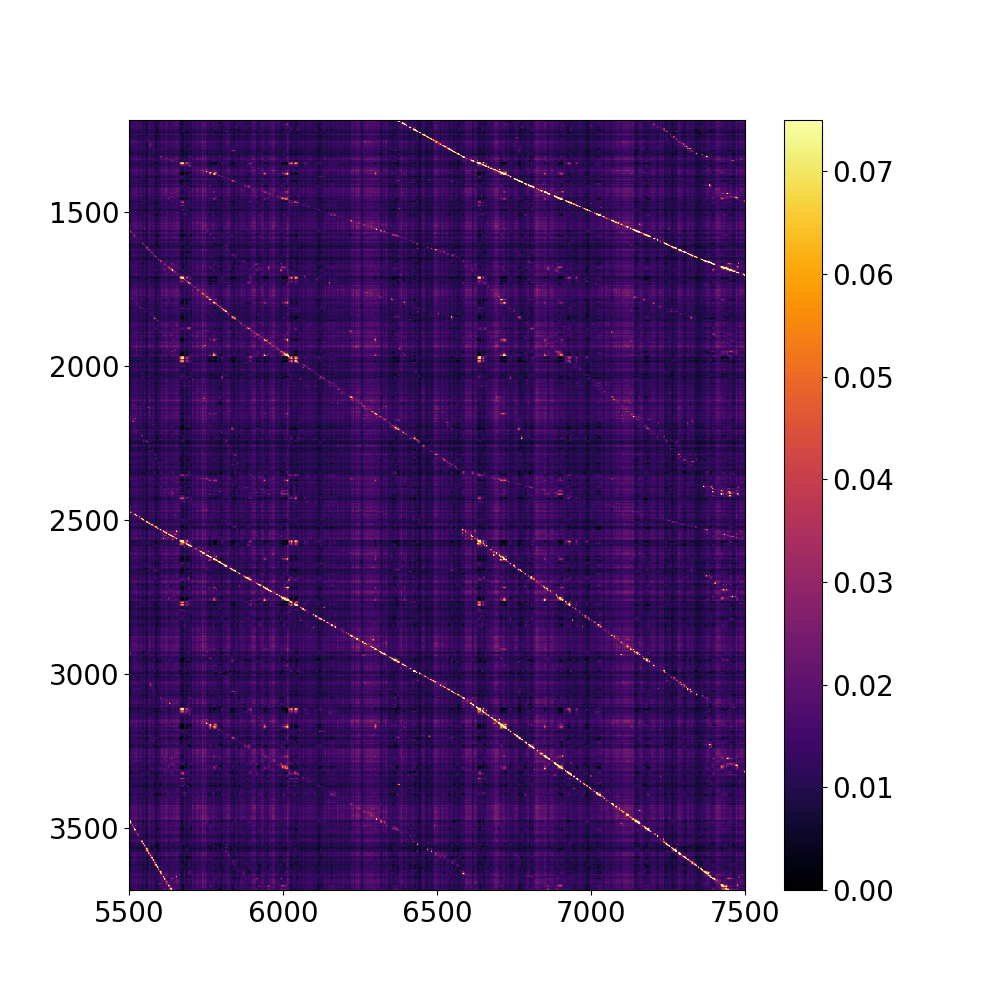

In [7]:
#FC from PS
plt.close('all')
plt.figure(figsize=(10,10))
plt.ylim(3700,1200)
plt.xlim(5500,7500)
#plt.ylim(10000,9000)
#plt.xlim(11000,12000)
plt.imshow(FC_data, vmin=0, vmax=0.075, cmap='inferno')

plt.colorbar()

<IPython.core.display.Javascript object>


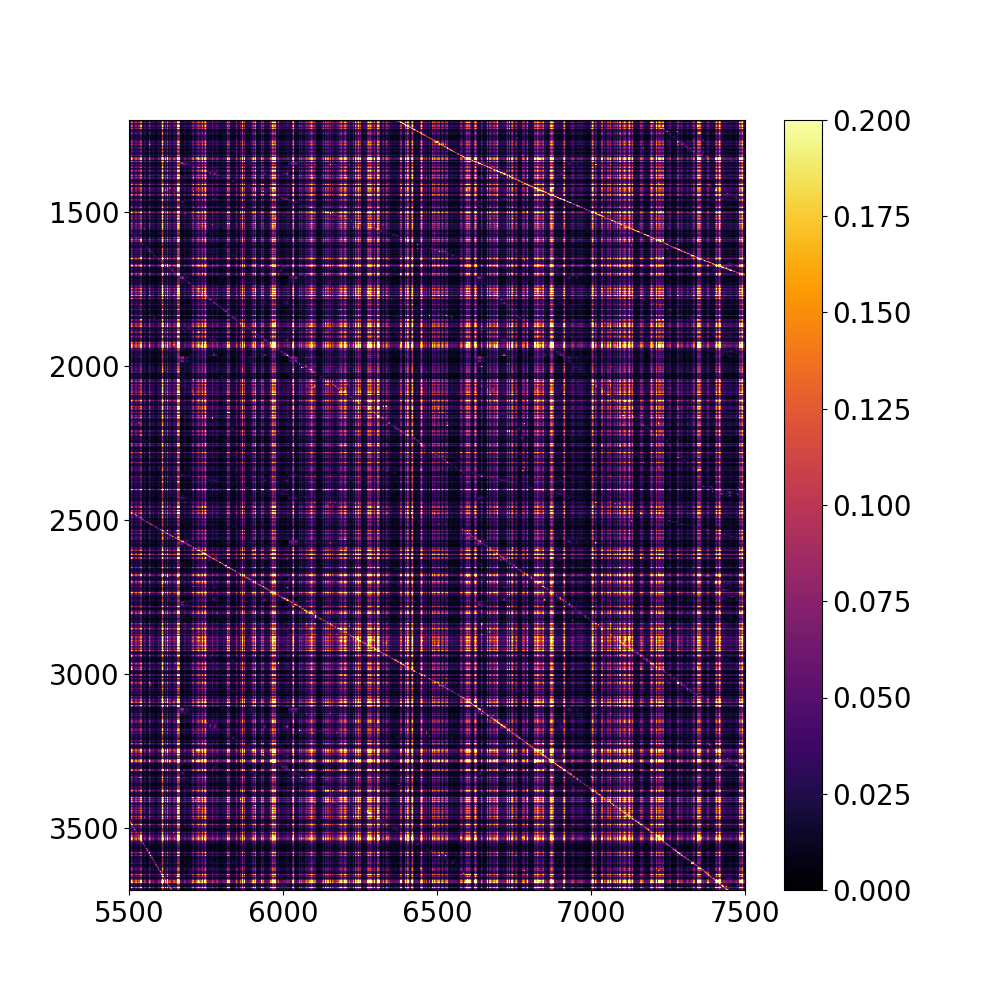

In [8]:
#FC from PS (no k>15000)
plt.close('all')
plt.figure(figsize=(10,10))
plt.ylim(3700,1200)
plt.xlim(5500,7500)
#plt.ylim(10000,9000)
#plt.xlim(11000,12000)
plt.imshow(FC_data, vmin=0, vmax=0.2, cmap='inferno')

plt.colorbar()

In [26]:
model_FC = Functional_Connectivity(eigenvectors, NF_to_empirical(scale_params_spatial,Gk_E,Gk_I), False)

<IPython.core.display.Javascript object>


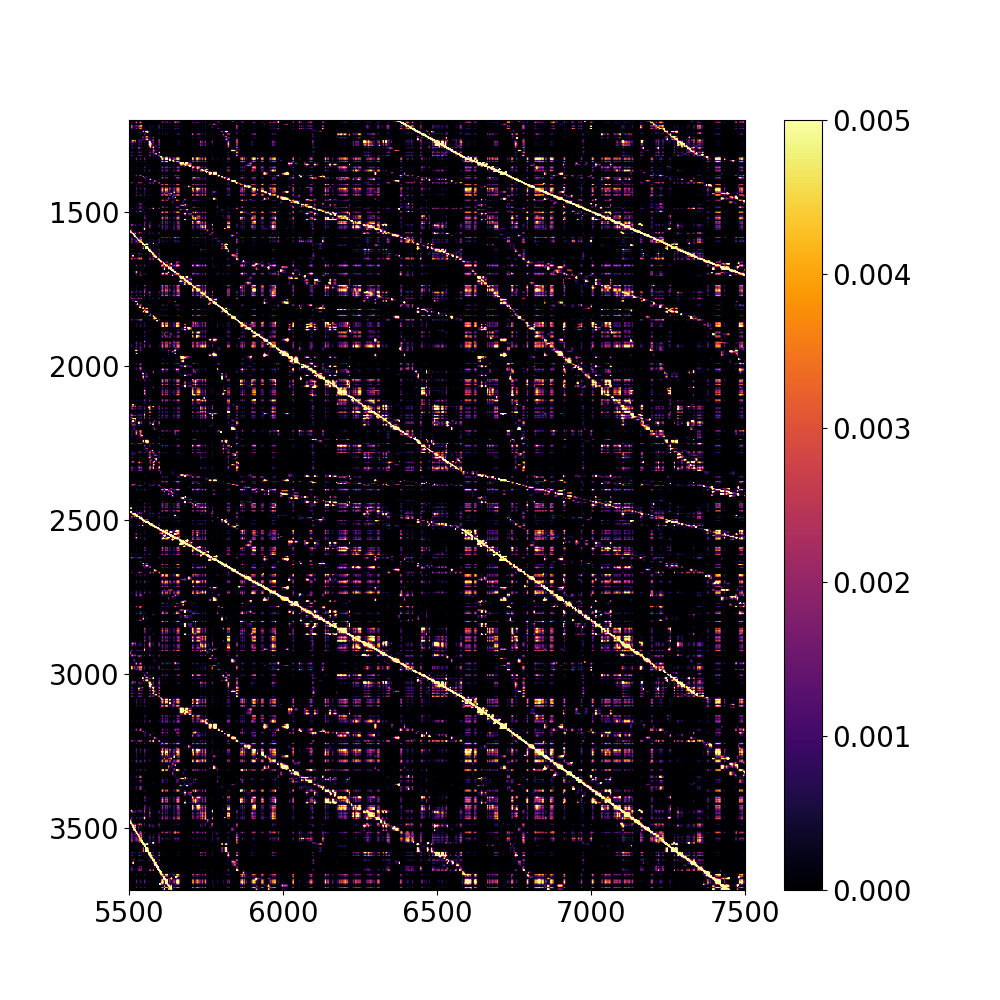

In [34]:
plt.close('all')
plt.figure(figsize=(10,10))
plt.imshow(model_FC, vmin=0, vmax=0.005, cmap='inferno')
plt.ylim(3700,1200)
plt.xlim(5500,7500)
#plt.ylim(10000,9000)
#plt.xlim(11000,12000)
plt.colorbar()
#plt.savefig('/Volumes/Crucial X8/NFModel_revision_figures/FC/model_FC_inset2_highdpi.pdf', dpi=600, bbox_inches='tight')

In [7]:
cov_gfd = np.cov(coeffs)
cov_diag = np.diag(cov_gfd)
#cov_gfd[15000:,15000:] = 0
#cov_gfd[np.eye(len(eigenvalues)).astype('bool')] = cov_diag
cov_gd = np.dot(eigenvectors,np.dot(np.diag(cov_diag),eigenvectors.T))
norm_corr = np.diag(np.power(np.diag(cov_gd),-0.5))
FC_data = np.dot(norm_corr,np.dot(cov_gd,norm_corr))

In [ ]:
corr_gfd = np.corrcoef(coeffs)
plt.close('all')
plt.figure(figsize=(10,10))
#plt.ylim(3700,1200)
#plt.xlim(5500,7500)
#plt.ylim(100,0)
#plt.xlim(0,100)
plt.imshow(corr_gfd, vmin=0, vmax=0.3, cmap='inferno')
plt.colorbar()

In [ ]:
upp = corr_gfd[np.triu_indices_from(corr_gfd,k=1)]
plt.close('all')
plt.figure()
plt.hist(upp,bins=10000)

In [ ]:
print(sp.stats.shapiro(upp))
print(sp.stats.anderson(upp))
print(sp.stats.kstest(upp,'norm',N=175116255))

In [30]:
print(np.median(upp))
print(sp.stats.describe(upp))

DescribeResult(nobs=175116255, minmax=(-0.9198269643481842, 0.9210314882269546), mean=-4.343254815518911e-06, variance=0.0013828841933523693, skewness=0.0011389382799583349, kurtosis=1.43070838180288)


In [ ]:
FC_data = np.zeros_like(FC_data)
for i in range(12):
    print(i)
    FC_data += np.nan_to_num(np.corrcoef(dem_tc[:,i*100:(i+1)*100-1]-dem_tc[:,i*100:(i+1)*100-1].mean(1)[...,np.newaxis]))
FC_data/=12

# verification of LSD 2017 PS definition

In [ ]:
#this it the only rigorous definition of Power Spectrum. In words:
#"The power spectrum is the mean of the squared modulus of the Fourier coefficients"
#the modulus is redundant here since all our coefficients are Real, but I keep it for formality
empirical_SPS_forplot = median_binning((np.abs(coeffs)**2).mean(1)[first_k:last_k], bins)
empirical_SPS_zscore_forplot = median_binning((np.abs(coeffs_zscore)**2).mean(1)[first_k:last_k], bins)

#this is the quantity plotted in the first row of LSD 2017 paper
LSD2017_1 = median_binning((np.abs(coeffs)).max(1)[first_k:last_k], bins)
LSD2017_1_zscore = median_binning((np.abs(coeffs_zscore)).max(1)[first_k:last_k], bins)

#this is the quantity plotted in the second row of LSD 2017 paper
LSD2017_2 = median_binning((np.abs(coeffs)).mean(1)[first_k:last_k], bins)
LSD2017_2_zscore = median_binning((np.abs(coeffs_zscore)).mean(1)[first_k:last_k], bins)

#this is the quantity plotted in the third row of LSD 2017 paper
LSD2017_3 = median_binning(np.std(np.abs(coeffs), axis=1)[first_k:last_k], bins)
LSD2017_3_zscore = median_binning(np.std(np.abs(coeffs_zscore), axis=1)[first_k:last_k], bins)

In [ ]:
plt.figure()
plt.loglog(empirical_SPS_forplot, label='Power Spectrum', linestyle='-', marker='o', markersize=3)
plt.loglog(LSD2017_1, label='LSD2017 row 1', linestyle='-', marker='o', markersize=3)
plt.loglog(LSD2017_2, label='LSD2017 row 2', linestyle='-', marker='o', markersize=3)
plt.loglog(LSD2017_3, label='LSD2017 row 3', linestyle='-', marker='o', markersize=3)
plt.loglog(LSD2017_3**2, label='LSD2017 row 3 squared', linestyle='-', marker='o', markersize=3)
plt.legend(prop={'size': 12})

In [ ]:
plt.figure()
plt.loglog(empirical_SPS_zscore_forplot, label='Z-scored Power Spectrum', linestyle='-', marker='o', markersize=3)
plt.loglog(LSD2017_1_zscore, label='Z-scored LSD2017 row 1', linestyle='-', marker='o', markersize=3)
plt.loglog(LSD2017_2_zscore, label='Z-scored LSD2017 row 2', linestyle='-', marker='o', markersize=3)
plt.loglog(LSD2017_3_zscore, label='Z-scored LSD2017 row 3', linestyle='-', marker='o', markersize=3)
plt.loglog(LSD2017_3_zscore**2, label='Z-scored LSD2017 row 3 squared', linestyle='-', marker='o', markersize=3)
plt.legend(prop={'size': 12})

# empirical harmonic and temporal spectra

In [6]:
#empirical_SPS_errors = np.abs(np.dot(eigenvectors.T,errors)).mean(1)
empirical_SPS=(np.abs(coeffs)**2).mean(1)[first_k:last_k]
#keep the [:-1] to avoid empty slice problems
bins = np.unique(np.logspace(np.log10(first_k), np.log10(last_k), num=300, dtype=int))[:-1]
binned_SPS = np.array([np.median(elem) for elem in np.array_split(empirical_SPS, bins)])
binned_SPS_points = np.array([elem.mean() for elem in np.array_split(np.arange(first_k,last_k), bins)])
binned_SPS_err = np.array([sp.stats.sem(elem) for elem in np.array_split(empirical_SPS, bins)])
len(bins)

/Users/marcoaqil/anaconda3/envs/prfpy_2021/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/marcoaqil/anaconda3/envs/prfpy_2021/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


222

<IPython.core.display.Javascript object>


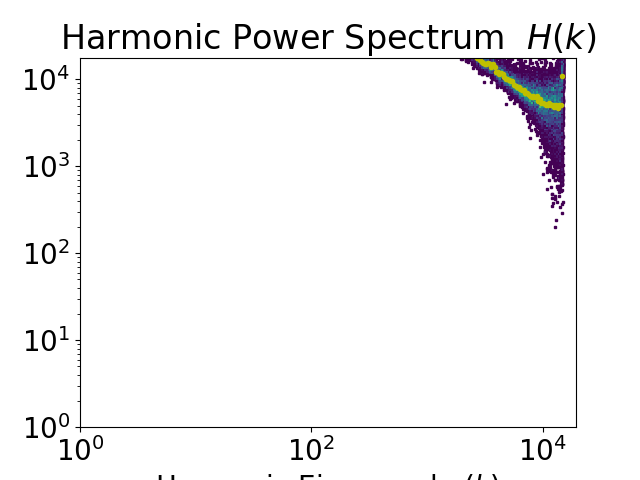

<IPython.core.display.Javascript object>


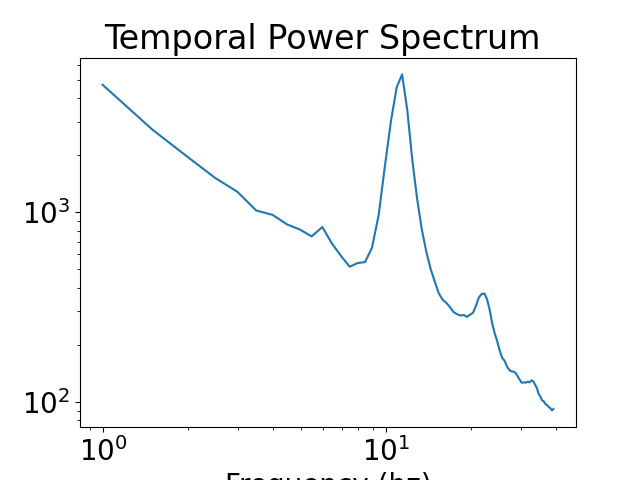

In [7]:

plt.figure()
plt.yscale('log')
plt.xscale('log')
plt.title("Harmonic Power Spectrum  $H(k)$")
plt.xlabel("Harmonic Eigenmode ($k$)")
#plt.errorbar(x=np.arange(len(empirical_SPS)), y=empirical_SPS, yerr=0, fmt='ks', markersize=1, zorder=1)
plt.errorbar(x=binned_SPS_points, y=binned_SPS, yerr=binned_SPS_err, zorder=2, fmt='yo',markersize=3)

plt.loglog(np.arange(first_k, last_k), empirical_SPS, marker='s', linestyle='', markersize=2, zorder=0, color=[0.267004, 0.004874, 0.329415, 1.])
plot_bins = np.unique(np.logspace(0, np.log10(20000), num=300, dtype=int))[:-1]
y_bins = np.unique(np.logspace(0, np.log10(18715), num=200, dtype=int))[:-1]
plt.hist2d(np.arange(first_k, last_k), empirical_SPS, (plot_bins, y_bins), cmap='viridis',zorder=1,cmin=2)

fit_to_median=True
if fit_to_median:
    True_Spatial_Spectrum = binned_SPS
    Bins=bins
else:
    True_Spatial_Spectrum = empirical_SPS
    Bins=None
        
LSA=True
Visual=False
SaveFiles=False
FilePath=' '

#note this is re-set below in this cell and when doing simulations
Min_omega=0.5*(2*np.pi)
Max_omega=100*(2*np.pi)
Delta_omega=0.1*(2*np.pi)

freqs=np.arange(Min_omega,Max_omega,Delta_omega)/(2*np.pi)

#higher gaussian TPS
higher_gaussian_TPS=100000/(100*freqs+10000)+5*np.exp((-(freqs-10)**2)/(2*0.9**2))
#lower gaussian TPS
lower_gaussian_TPS=100000/(100*freqs+10000)+3*np.exp((-(freqs-10)**2)/(2*1.2**2)) #too complex: 10*(1/(0.1*freqs+0.4)+0.7*np.exp((-(freqs-10)**2)/(2*0.9**2))+0.3*np.exp((-(freqs-22)**2)/(2*3**2)))
#even lower gaussian TPS
even_lower_gaussian_TPS=100000/(100*freqs+10000)+1.5*np.exp((-(freqs-10)**2)/(2*1.8**2))
#lowest gaussian TPS
lowest_gaussian_TPS=100000/(100*freqs+10000)+0.5*np.exp((-(freqs-10)**2)/(2*2.5**2))
#no gaussian TPS
no_gaussian_TPS=100000/(100*freqs+10000)

#new TPS, inspired by ketamine paper. suitable for loglog plotting, so multiplicative factor
new_TPS=2.5*freqs**(-1.25)+1.2*np.exp((-(freqs-10)**2)/(2*0.7**2)) + 0.06*np.exp((-(freqs-20)**2)/(2*0.7**2))
new_TPS[np.where((freqs>20) & (freqs<=40))] = 35*freqs[np.where((freqs>20) & (freqs<=40))]**(-2.17) +0.06*np.exp((-(freqs[np.where((freqs>20) & (freqs<=40))]-20)**2)/(2*0.7**2))
new_TPS[np.where(freqs>40)] = 1.17*freqs[np.where(freqs>40)]**(-1.25)

#empirical TPS from Rikkert MEG data
MEG_PS_data = sp.io.loadmat('MEG_powerspectrum.mat')
freqs = MEG_PS_data['f'][1:][:,0]
empirical_TPS = MEG_PS_data['p'].T[1:][:,0] * 10 **30#28
Min_omega=1*(2*np.pi)
Max_omega=40*(2*np.pi)
Delta_omega=0.5*(2*np.pi)
True_Temporal_Spectrum=np.array(empirical_TPS, dtype='float')#[int(len(new_TPS)*0.1):int(len(new_TPS)*0.5)]
#Max_omega=25*(2*np.pi)


fig2 = plt.figure()
ax = fig2.add_subplot(111)
ax.set_title("Temporal Power Spectrum ")
ax.set_xlabel("Frequency (hz)")
ax.loglog(freqs, True_Temporal_Spectrum)

#change none to True_Spatial_Spectrum if want to fit to both
Args = (eigenvalues, Graph_Kernel, None, Min_omega, Max_omega, Delta_omega, True_Spatial_Spectrum, first_k, last_k, Bins, LSA, Visual, SaveFiles, FilePath)

# Param fitting and results

In [ ]:
############################
#single analysis for easy visualization (note that if there are multiple stedy states the visualization will refer to the best one)
# better_result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#        1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#        8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#        4.95497870e+00, 4.47579295e+00]))
#Set parameters and bounds for minimization algorithms
aEE, bnds_aEE = 140, (0,1e4)
aIE, bnds_aIE = 155, (0,1e4)
aEI, bnds_aEI = 165, (0,1e4)
aII, bnds_aII = 140, (0,1e4)
dE, bnds_dE = 2, (0,1e4)
dI, bnds_dI = 2, (0,1e4)
P, bnds_P = 0, (-1e4,1e4)
Q, bnds_Q = 0, (-1e4,1e4)
sEE, bnds_sEE = 6, (0,1e4)
sIE, bnds_sIE = 10, (0,1e4)
sEI, bnds_sEI = 10, (0,1e4)
sII, bnds_sII = 50, (0,1e4)
#D, bnds_D = 1, (0.1,10)             #unchanged
tE, bnds_tE = 1, (0,1e4)          
tI, bnds_tI = 1, (0,1e4)          
#snE, bnds_snE = 1, (1,10)        #unchanged
#snI, bnds_snI = 1, (1,10)         #unchanged

initial_guess=np.array([aEE,aIE,aEI,aII,dE,dI,P,Q,sEE,sIE,sEI,sII,tE,tI])#,snE])#,snI]) 
bnds=[bnds_aEE,bnds_aIE,bnds_aEI,bnds_aII,bnds_dE,bnds_dI,bnds_P,bnds_Q,bnds_sEE,bnds_sIE,bnds_sEI,bnds_sII,bnds_tE,bnds_tI]#,bnds_snE]#,bnds_snI]

aEE=115
aIE=175
aEI=190 
aII=210
dE=2.5 
dI=1 
P=0 
Q=0 
sEE=5.5 
sIE=3
sEI=3.5 
sII=100 
tE=1.2
tI=0.8
initial_guess=np.array([aEE,aIE,aEI,aII,dE,dI,P,Q,sEE,sIE,sEI,sII,tE,tI])
#Full_Analysis(better_result['x'], *Args)

In [ ]:
############################
#simple attempt at power spectrum fitting with a minimization algorithm. May get stuck in local minima.
#playing around with tolerance and max number of iterations is often necessary, depending on initial conditions. e.g.
#First run with fairly random initial guess: tol=1e-03, no maxiter (will take a while)
#Run starting from a previously obtained result: tol=1e-08, 'maxiter':2000
#thesis values
result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
       1e3*8.37626732e+00, 1e3*2.74681544e+00, 1e3*3.66503548e-02, 1e3*1.00910684e+02,
       4.95497870e+00, 4.47579295e+00]))

In [8]:
result=dict(x=np.array([6.88112381e+02, 7.85722370e+01, 9.97105458e+02, 1.22114834e+02,
 1.00095980e+02 ,8.71706788e+00 ,4.45444506e+00, 6.72211504e+00,
 2.69548038e-03 ,1.94174600e-03, 1.55065050e-02, 2.22532549e-01,
 7.02896805e-01, 2.03388273e-01]))
result=dict(x=np.array([3.21305207e+02, 1.15229271e+02 ,2.70650624e+02, 1.50968021e+02,
 9.72193535e+01, 2.21122739e-01, 1.40493267e+01, 6.38403082e+00,
 2.84332179e-03, 1.20034605e-02 ,5.54375346e-02, 6.13375039e-02,
 5.39616943e-04, 2.34386738e-05]))
#best linear fit with intercept (also simulated)
result=dict(x=np.array([2.68360960e+02, 1.47992427e+02, 3.40781188e+02, 1.39064758e+02,
 3.91998061e+01 ,1.49887889e+00, 2.16422343e+01, 1.48126196e+01,
 1.80443833e-02, 2.01119682e-03 ,7.65031385e-02 ,3.47241530e-02,
 1.50660781e-01 ,1.30547616e+00]))

result=dict(x=np.array([1.50168054e+02, 2.19398694e+02, 2.60282590e+02, 1.61754514e+02,
 2.66754985e+01 ,1.23424895e+00, 2.22845573e+01, 8.44527415e+00,
 1.61870040e-02, 2.01464558e-03 ,6.87269629e-02, 1.03620878e-01,
 1.90996952e-01 ,2.41407765e-01]))
#final
result=dict(x=np.array([1.48665460e+02, 2.19057310e+02 ,2.62024638e+02 ,1.61437274e+02,
 2.71802361e+01, 1.24033047e+00, 2.23516416e+01 ,8.45022796e+00,
 1.61138979e-02, 2.02249219e-03 ,6.69814861e-02 ,9.14930664e-02,
 2.02440304e-01, 2.34608894e-01]))


In [ ]:
initial_guess=result['x']#better_result['x']

result = sp.optimize.minimize(Full_Analysis, initial_guess, args=Args,
                              method='Nelder-Mead', 
                              bounds=bnds, 
                              tol=1e-16,
                              options={#'ftol':1e-10,
                                      # 'xtol':1e-16,
                                       'maxiter': 10000,
                                  'adaptive':True,
                                  #      'maxls':50,
                                       'disp':True})

In [ ]:
############################
#more complicated fitting attempt with basinhopping stochastic minimization
#to obtain good results in sensible amounts of time, playing with minimization parameters is required
#the relevant parameter are again tolerance and maxiter, similarly to above (which affect the local minimization loop)
#but also niter and stepsize. these specify how many local minimizations we wish to carry out, 
#and the size of the basin-hopping random step inbetween local minimizations

#best previous spectrum
new_initial_guess=result['x']

#spectrum (thesis)
#old_initial_guess=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#       4.95497870e+00, 4.47579295e+00])

#new_initial_guess=np.load('first_spatiotemporal_spectrum_empirical_stps.npy', allow_pickle=True)[()]['x']

#sort of ugly, but need to defind bounds manually for basinhopping
class MyBounds(object):
    def __init__(self, xmax=[elem[1] for elem in bnds], xmin=[elem[0] for elem in bnds]):#, hello=this_temporal_distance):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
        #self.hello = hello
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        t=tmax and tmin
        
        New_Dist=Full_Analysis(x, eigenvalues, Graph_Kernel, True_Temporal_Spectrum, Min_omega, Max_omega, Delta_omega, True_Spatial_Spectrum, first_k, LSA, Visual, SaveFiles)
        
        success = New_Dist<1e6
        
        #if t and success and New_Dist<self.hello:
        #    self.hello=New_Dist
        #    new_initial_guess=np.copy(x)
        
        return t and success
    
    
    #potential TODO: only accept parameter sets that return stable positive steady states (actually no: they might be locally near a suitable state. still worth to do local minimization)

#minimizer_kwargs={'args':Args, 'method':'TNC', 'bounds':bnds, 'tol':1e-03, 'options':{'maxiter':500}}


def custom_min(fun, x0, args, **kwargs):
    Bounds=bnds
    #Bounds[0:8]=[(elem,elem) for elem in x0[0:8]]
         
    result = sp.optimize.minimize(fun,x0,args=Args, method='L-BFGS-B',# bounds=Bounds,
                                #tol=1e-16,
                                options={'maxiter':2000, 
                                        # 'ftol': 1e-10,
                                        # 'maxls': 100,
                                         'disp':True})
    print(result)
    
    return result


# better_result = sp.optimize.basinhopping(Full_Analysis, new_initial_guess, niter=1, stepsize=10,
#                                   minimizer_kwargs=dict(method=custom_min),
#                                   accept_test=MyBounds(), disp=True)

Init=np.stack((new_initial_guess,new_initial_guess,new_initial_guess,new_initial_guess,new_initial_guess))


better_result = sp.optimize.differential_evolution(Full_Analysis, bounds=bnds, 
                                                 args=Args, tol=1e-10, disp=True, init=Init,
                                                 maxiter=25000, polish=True, workers=-1) #recombination=0.1,
                                                 #updating='deferred',
                                                #mutation=0)


# Re-analyze result of minimization procedure

[[0.00812777]
 [0.1006278 ]]


<IPython.core.display.Javascript object>


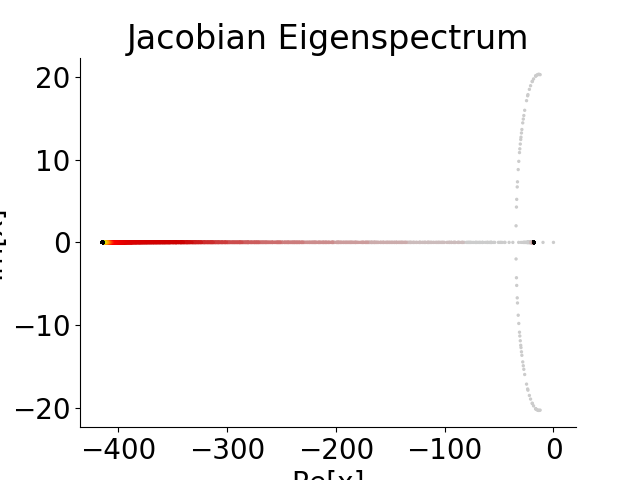

E*=0.0081, I*=0.1006: stable, with nonzero imaginary components


<IPython.core.display.Javascript object>


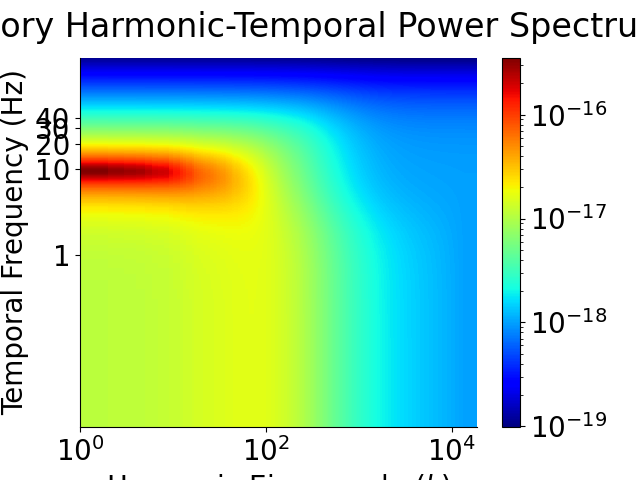

/Users/marcoaqil/Documents/Dropbox/Amsterdam Math/Rikkert Hindriks/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:417: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc=plt.pcolormesh(np.arange(1,len(eigs)),omegas/(2*np.pi),E_Full_Spectrum.T[:,1:],norm=pltcolors.LogNorm(), cmap='jet')


<IPython.core.display.Javascript object>


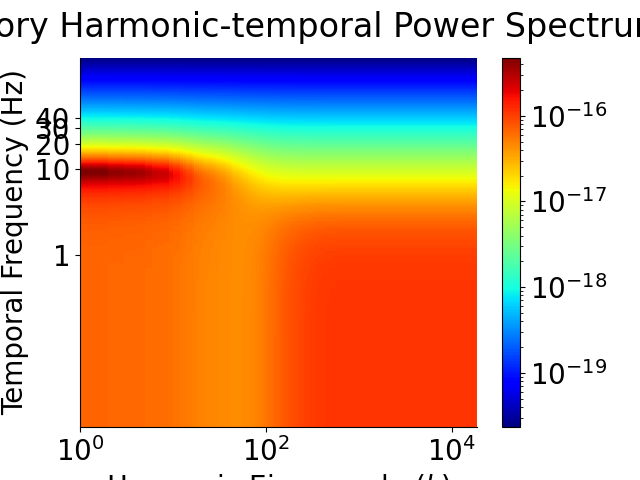

/Users/marcoaqil/Documents/Dropbox/Amsterdam Math/Rikkert Hindriks/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:434: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc_2=plt.pcolormesh(np.arange(1,len(eigs)),omegas/(2*np.pi),I_Full_Spectrum.T[:,1:],norm=pltcolors.LogNorm(), cmap='jet')


<IPython.core.display.Javascript object>


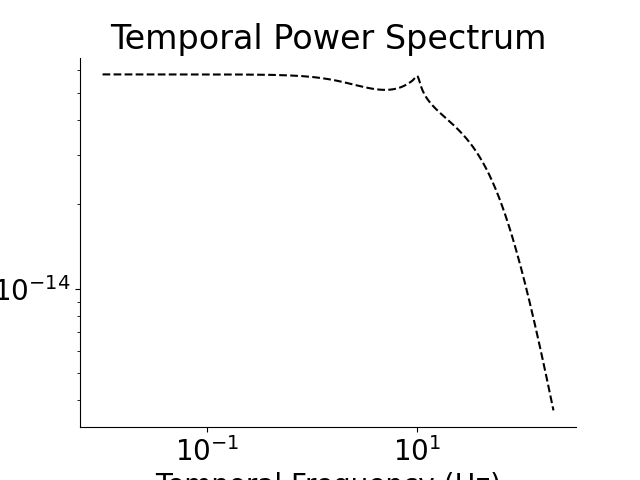

<IPython.core.display.Javascript object>


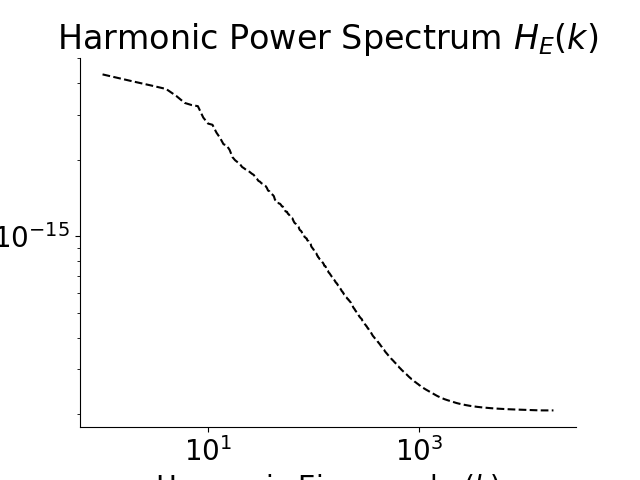

In [19]:
#re-analyze result of minimization procedure

#thesis parameters
#better_result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#       4.95497870e+00, 4.47579295e+00]))

#better_result=np.load('decent_spatiotemporal_spectrum.npy', allow_pickle=True)[()]
#better_result=np.load('decent_spatiotemporal_spectrum_lower_gauss.npy', allow_pickle=True)[()]
#better_result=np.load('decent_spatiotemporal_spectrum_even_lower_gauss.npy', allow_pickle=True)[()]
#better_result=np.load('decent_spatiotemporal_spectrum_lowest_gauss.npy', allow_pickle=True)[()]
#better_result=np.load('decent_spatiotemporal_spectrum_lower_gauss_no_spatial_peak.npy', allow_pickle=True)[()]

#IMPORTANT: if using spectra above, run the line below, since they were not done in metres
#better_result['x'][8:12]/=1000

#used this for 1D simulations/analysis
better_result=np.load('decent_spatiotemporal_spectrum_first_new_realistic_metres.npy', allow_pickle=True)[()]

#better_result=np.load('spatiotemporal_spectrum_empirical_tps.npy', allow_pickle=True)[()]
#better_result=np.load('spatiotemporal_spectrum_empirical_sps.npy', allow_pickle=True)[()]
#better_result=np.load('first_spatiotemporal_spectrum_empirical_stps.npy', allow_pickle=True)[()]

#better_result = np.load('stps_empirical_loglog_median_fitting.npy', allow_pickle=True)[()]

#final
# better_result = dict(x=np.array([1.48665460e+02, 2.19057310e+02 ,2.62024638e+02 ,1.61437274e+02,
#  2.71802361e+01, 1.24033047e+00, 2.23516416e+01 ,8.45022796e+00,
#  1.61138979e-02, 2.02249219e-03 ,6.69814861e-02 ,9.14930664e-02,
#  2.02440304e-01, 2.34608894e-01]))


#better_result = result

SStates, success = H_Simple_Steady_State(alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], 
                                         d_e=better_result['x'][4], d_i=better_result['x'][5], P=better_result['x'][6], Q=better_result['x'][7])
print(SStates)       

SSnr=0
sigma_noise=0.0000001

Min_omega=0.01*(2*np.pi)
Max_omega=200*(2*np.pi)
Delta_omega=0.1*(2*np.pi)

SStype, found_suitable, JacEigs = GraphWC_Jacobian_TrDet(Laplacian_eigenvalues=eigenvalues, Graph_Kernel='Gaussian', Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                     alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                     sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                     D=1, tau_e=better_result['x'][12], tau_i=better_result['x'][13], Visual=True)    


E_Spectrum, I_Spectrum = Graph_WC_Spatiotemporal_PowerSpectrum(Laplacian_eigenvalues=eigenvalues, Graph_Kernel='Gaussian', Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                        alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                        sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                        D=1, tau_e=better_result['x'][12], tau_i=better_result['x'][13],
                                        sigma_noise_e=sigma_noise, sigma_noise_i=sigma_noise,
                                        min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,
                                        Spatial_Spectrum_Only=False, Visual=True)

Spectrum_spatial_only = Graph_WC_Spatiotemporal_PowerSpectrum(Laplacian_eigenvalues=eigenvalues, Graph_Kernel='Gaussian', Ess=SStates[0,SSnr], Iss=SStates[1,SSnr],
                                        alpha_EE=better_result['x'][0], alpha_IE=better_result['x'][1], alpha_EI=better_result['x'][2], alpha_II=better_result['x'][3], d_e=better_result['x'][4], d_i=better_result['x'][5], 
                                        sigma_EE=better_result['x'][8], sigma_IE=better_result['x'][9], sigma_EI=better_result['x'][10], sigma_II=better_result['x'][11],  
                                        D=1, tau_e=better_result['x'][12], tau_i=better_result['x'][13],
                                        sigma_noise_e=sigma_noise, sigma_noise_i=sigma_noise,
                                        min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega,
                                        Spatial_Spectrum_Only=True, Visual=True)


#import plotly.graph_objs as go
#from plotly.offline import init_notebook_mode, plot
#init_notebook_mode(connected=True)

#data = [go.Surface(
#                                x=np.arange(1,len(eigenvalues)+1),
#                                y=freqs,
#                                z=Spectrum.T
#                                )
#                ]

#layout = go.Layout(scene=dict(
#    xaxis=dict(
#        type='log',
#        autorange=True
#    ),
#    yaxis=dict(
#        type='log',
#        autorange=True
#    ),
#    zaxis=dict(
#        type='log',
#        autorange=True
#    ))
#)
#fig_ly = go.Figure(data=data, layout=layout)
#plot(fig_ly,filename='E:\whatever.html')



In [52]:
E_Spectrum.shape

cov = np.dot(10**15*E_Spectrum.T,10**15*E_Spectrum)
corr = np.dot(np.diag(np.diag(cov)**-0.5),np.dot(cov,np.diag(np.diag(cov)**-0.5)))

In [ ]:
plt.close('all')
plt.figure(figsize=(10,10))
#plt.ylim(3700,1200)
#plt.xlim(5500,7500)
#plt.ylim(10000,9000)
#plt.xlim(11000,12000)
plt.imshow(corr, vmin=0, vmax=1, cmap='inferno')

plt.colorbar()

<IPython.core.display.Javascript object>


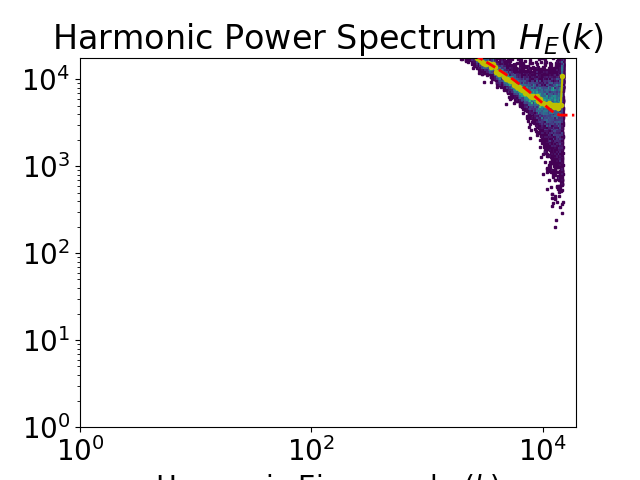

spatial scale factors: [4.27171633e+18]
spatial distance: 910.2136281010376
KstestResult(statistic=0.5838452010403086, pvalue=8.481190445890096e-72)
KstestResult(statistic=0.1031390134529148, pvalue=0.18661483323606723)


<IPython.core.display.Javascript object>


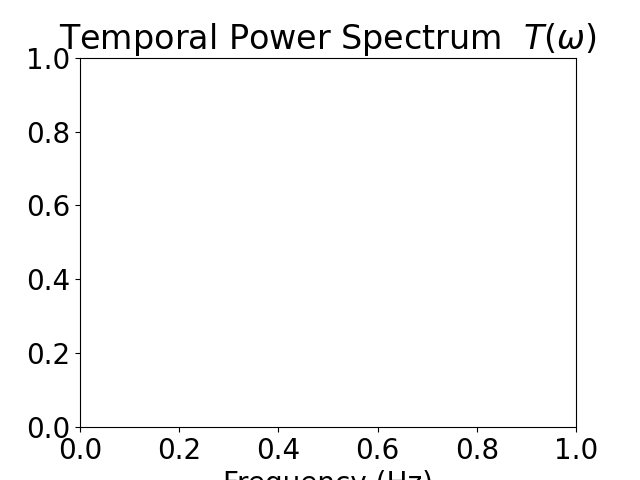

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2000 and the array at index 3 has size 78

In [10]:
#import seaborn as sns
#from analysis import find_scaling, NF_to_empirical
Gk_E=Spectrum_spatial_only[:,0,0] #Delta_omega*np.sum(Spectrum,axis=0)/np.pi
Gk_I=Spectrum_spatial_only[:,1,1]
Gw_E=2*np.sum(E_Spectrum,axis=1)
Gw_I=2*np.sum(I_Spectrum,axis=1)
plt.ion()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Harmonic Power Spectrum  $H_E(k)$")
ax.set_xlabel("Harmonic Eigenmode ($k$)")

if not fit_to_median:
    E_spatial_spectrum = Gk_E
    I_spatial_spectrum = Gk_I
    SPS_points = np.arange(first_k,last_k)
else:
    E_spatial_spectrum = np.array([np.median(elem) for elem in np.array_split(Gk_E[first_k:last_k], bins)])
    I_spatial_spectrum = np.array([np.median(elem) for elem in np.array_split(Gk_I[first_k:last_k], bins)])
    SPS_points = np.array([elem.mean() for elem in np.array_split(np.arange(first_k,last_k), bins)])

    
# a_matrix_spatial = np.vstack((E_spatial_spectrum,
#                               I_spatial_spectrum,
#                               E_spatial_spectrum*I_spatial_spectrum,
#                               np.ones_like(True_Spatial_Spectrum))).T

# scale_params_spatial = np.linalg.lstsq(a_matrix_spatial, True_Spatial_Spectrum)[0]    
scale_params_spatial = sp.optimize.fmin(find_scaling, x0=[1e4], args=(E_spatial_spectrum,I_spatial_spectrum,True_Spatial_Spectrum), disp=0)

# n_spatial = len(True_Spatial_Spectrum)    
# a_spatial = (n_spatial*np.dot(E_spatial_spectrum,True_Spatial_Spectrum)-np.sum(True_Spatial_Spectrum)*np.sum(E_spatial_spectrum))/(n_spatial*np.dot(E_spatial_spectrum,E_spatial_spectrum)-np.sum(E_spatial_spectrum)**2)
# b_spatial = (np.sum(True_Spatial_Spectrum)-a_spatial*np.sum(E_spatial_spectrum))/n_spatial
# scale_params_spatial = np.array([a_spatial,b_spatial])

current_spatial_spectrum = NF_to_empirical(scale_params_spatial,
                                           E_spatial_spectrum,
                                           I_spatial_spectrum)

#to avoid log10 throwing tantrums. but of course no "good" spectrum should have negative values                    
current_spatial_spectrum[current_spatial_spectrum<=0] = 1e-10

data_1=np.vstack((SPS_points, np.log10(True_Spatial_Spectrum))).T
data_2=np.vstack((SPS_points, np.log10(current_spatial_spectrum))).T

dist_spatial = sm.area_between_two_curves(data_1,data_2)+np.linalg.norm(np.log10(True_Spatial_Spectrum)-np.log10(current_spatial_spectrum), ord=1)**2

print("spatial scale factors: {}".format(scale_params_spatial))
print("spatial distance: {}".format(dist_spatial))

ax.loglog(np.arange(first_k, last_k), empirical_SPS, marker='s', linestyle='', markersize=2, zorder=0, color=[0.267004, 0.004874, 0.329415, 1.])
plot_bins = np.unique(np.logspace(0, np.log10(20000), num=300, dtype=int))[:-1]
y_bins = np.unique(np.logspace(0, np.log10(18715), num=200, dtype=int))[:-1]
ax.hist2d(np.arange(first_k, last_k), empirical_SPS, (plot_bins, y_bins), cmap='viridis',zorder=1,cmin=2)

ax.loglog(np.arange(1,len(eigenvalues)),  NF_to_empirical(scale_params_spatial,Gk_E,Gk_I)[1:], zorder=3,color='red', linestyle='--', linewidth=2)
plt.errorbar(x=binned_SPS_points, y=binned_SPS, yerr=binned_SPS_err, zorder=2, fmt='yo-',markersize=3)

print(sp.stats.ks_2samp(empirical_SPS,  current_spatial_spectrum))
print(sp.stats.ks_2samp(True_Spatial_Spectrum, current_spatial_spectrum))
      
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title("Temporal Power Spectrum  $T(\omega)$")
ax.set_xlabel("Frequency (Hz)")

freqs=np.arange(Min_omega,Max_omega,Delta_omega)

a_matrix_temporal = np.vstack((Gw_E,
                               Gw_I,
                               Gw_E*Gw_I,
                               np.ones_like(True_Temporal_Spectrum))).T

scale_params_temporal = np.linalg.lstsq(a_matrix_temporal, True_Temporal_Spectrum)[0]
#scale_params_temporal = sp.optimize.fmin(find_scaling, x0=[1,0], args=(Gw_E,Gw_I,True_Temporal_Spectrum), disp=0)

current_temporal_spectrum = NF_to_empirical(scale_params_temporal,
                                            Gw_E, Gw_I)

#to avoid log10 throwing tantrums. but of course no "good" spectrum should have negative values
#current_temporal_spectrum[current_temporal_spectrum<=0] = 1e-10

data_3=np.vstack((freqs,np.log10(True_Temporal_Spectrum))).T
data_4=np.vstack((freqs,np.log10(current_temporal_spectrum))).T

dist_temporal = sm.area_between_two_curves(data_3,data_4)
           
print("temporal scale factor: {}".format(scale_params_temporal))
print("temporal distance: {}".format(dist_temporal))

print(np.ma.corrcoef(True_Temporal_Spectrum, current_temporal_spectrum))
print(np.ma.corrcoef(True_Spatial_Spectrum, current_spatial_spectrum))


print(sp.stats.ks_2samp(True_Temporal_Spectrum, current_temporal_spectrum))

ax.loglog(freqs/(2*np.pi),
            current_temporal_spectrum)
ax.loglog(freqs/(2*np.pi), 
            True_Temporal_Spectrum)

#np.save('decent_spatiotemporal_spectrum.npy', better_result)
print(better_result['x'])


In [ ]:
#np.load('decent_spatiotemporal_spectrum_lower_gauss.npy')[()]['x']-better_result['x']
#current best (loglog space fitting)
[ 1.06682212e+03,  1.73415339e+02,  2.92699896e+03,  2.95074005e+02,
  9.07838853e+01,  3.19257788e+00,  7.47262994e+00, -1.76660214e-02,
  5.43684383e-04, -1.75210509e-09,  5.52478781e-04,  5.40207870e+04,
  9.29655089e+00,  3.27876977e-01]
#logspace excellent s2.16 t0.86 (kstat pval 0.21 0.68)
better_result['x'] [ 1.60298254e+03,  1.84931805e+02,  2.99551387e+03,  2.80138120e+02,
  9.29297308e+01,  1.22714483e+00,  7.24240357e+00,  3.71750330e-01,
  4.34632128e-04,  2.05916610e-05,  6.11898211e-04, -3.38503489e+10,
  6.93229886e+00,  1.51916190e-01]
#np.save('stps_empirical_first_loglog_median_fitting.npy', better_result)
[6.32352428e+02, 7.93766496e+01, 3.47535746e+02, 1.07039076e+02,
       1.56586247e+02, 4.22226636e+00, 1.54479298e+01, 2.49662094e+01,
       4.31042051e-02, 2.44534241e-03, 4.77988694e-02, 5.17697376e-02,
       1.37486268e-01, 6.30906093e-01])

better_result['x']=[ 1.06682212e+03,  1.73415339e+02,  2.92699896e+03,  2.95074005e+02,
  9.07838853e+01,  3.19257788e+00,  7.47262994e+00, -1.76660214e-02,
  5.43684383e-04, -1.75210509e-09,  5.52478781e-04,  5.40207870e+04,
  9.29655089e+00,  3.27876977e-01]

In [ ]:
#np.save('stps_empirical_loglog_median_fitting.npy', better_result)

In [ ]:
#comparison of numerical (nonlinear) simulations and (linearized) semi analytic results 
#(any parameter set; grid laplacian only):
#
#1) test for steady state calculation: simulate (with no noise) on a grid, start directly from SS solution.
#2) test for stability/instability/oscillations: add noise in the grid simulation for specific parameter sets
#3) test for power spectrum calculation: run noisy grid simulation and compare prediction with measured PS (see handwritten notes)
#
################################################################################################
#testing the correctness of the parameter fit procedure(full analysis + minimization algorithm) result
#(intended mainly for the better_result parameter set)
#
#retest minimization algorithm, with objective the current best-fit PS obtained and random initial condition. see if other parameter combinations give the same, ideally converge to same par. set
#
#check (via effect on linearized Jk eigenvalues) if a nearby hopf bifurcation can be induced by changing P or some other parameter 
#(to ask rikkert: do we want this as a prior requirement in minimization? would be hard but doable)
#

<IPython.core.display.Javascript object>


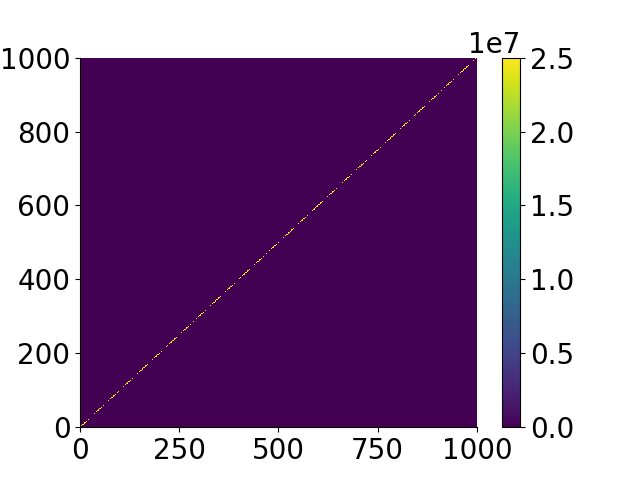

<IPython.core.display.Javascript object>


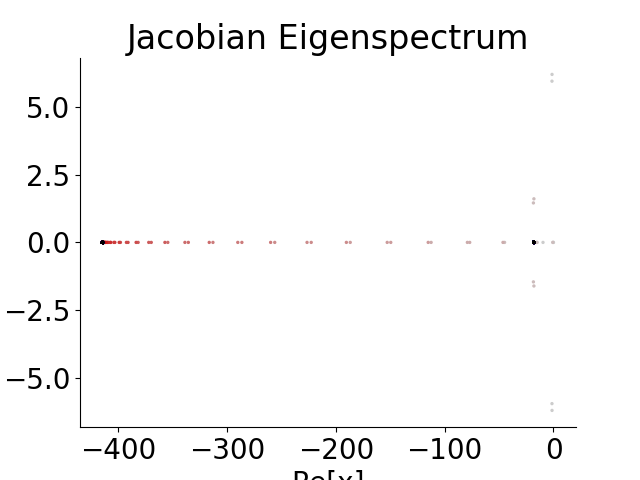

E*=0.0081, I*=0.1006: stable, with nonzero imaginary components


<IPython.core.display.Javascript object>


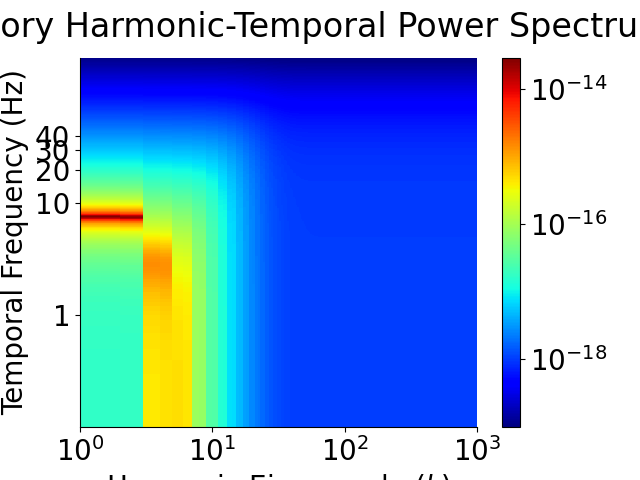

/Users/marcoaqil/Documents/Dropbox/Amsterdam Math/Rikkert Hindriks/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:417: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc=plt.pcolormesh(np.arange(1,len(eigs)),omegas/(2*np.pi),E_Full_Spectrum.T[:,1:],norm=pltcolors.LogNorm(), cmap='jet')


<IPython.core.display.Javascript object>


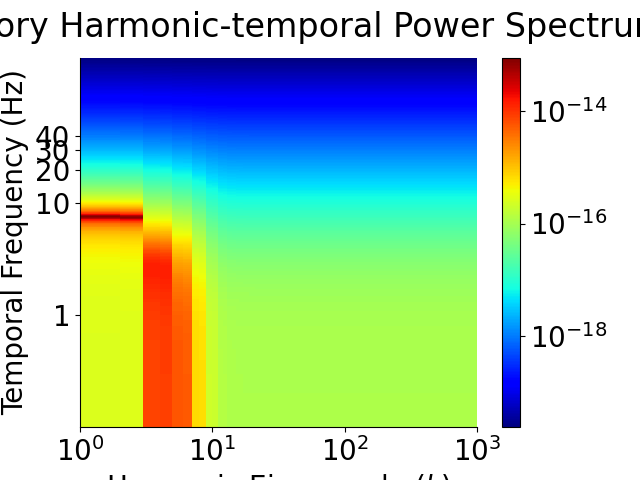

/Users/marcoaqil/Documents/Dropbox/Amsterdam Math/Rikkert Hindriks/Graph-Stochastic-Wilson-Cowan-Model/core/analysis.py:434: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc_2=plt.pcolormesh(np.arange(1,len(eigs)),omegas/(2*np.pi),I_Full_Spectrum.T[:,1:],norm=pltcolors.LogNorm(), cmap='jet')


<IPython.core.display.Javascript object>


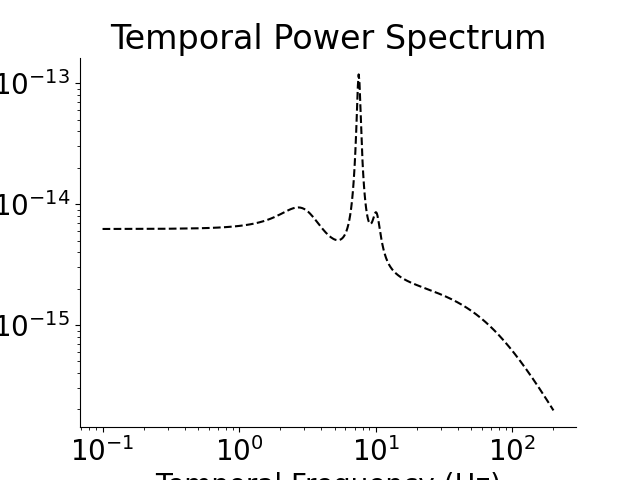

<IPython.core.display.Javascript object>


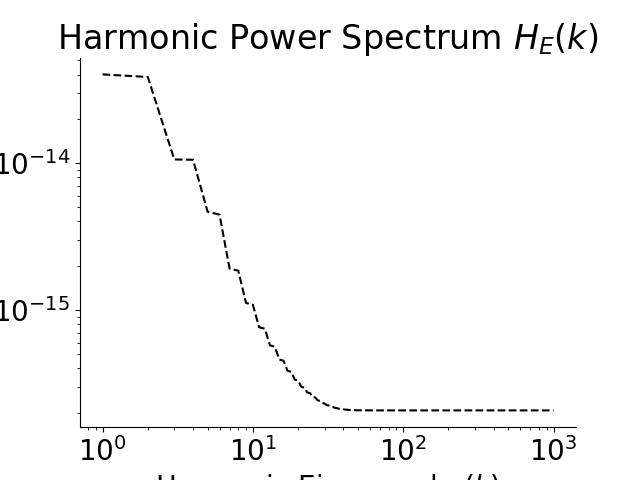

<IPython.core.display.Javascript object>


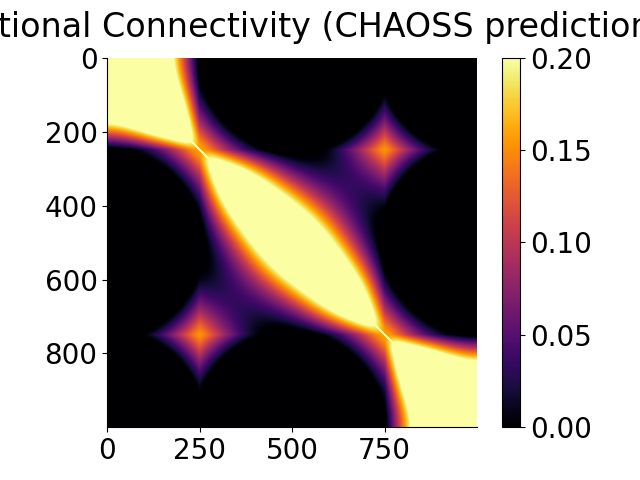

In [21]:
#1D predictions
#set up 1D-specific simulation parameters and WCM propagators
one_dim=False
syn=1
#if making plot from connectome minimization, need to change this value to the number of connectome nodes
gridsize=1000#len(eigenvalues)
h=0.0002
Min_omega=0.1*(2*np.pi)
Max_omega=200*(2*np.pi)
Delta_omega=0.1*(2*np.pi)

Graph_Kernel='Gaussian'
one_dim_eigenvalues, one_dim_eigenvectors = one_dim_Laplacian_eigenvalues(gridsize, h, syn, vecs=True)
#one_dim_eigenvalues2 = one_dim_Laplacian_eigenvalues(gridsize, h, syn)

#re-analyze result of minimization procedure
#better_result=np.load('decent_spatiotemporal_spectrum.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_lower_gauss.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_even_lower_gauss.npy')[()]

#better_result=np.load('decent_spatiotemporal_spectrum_lowest_gauss.npy')[()]

#thesis result
#better_result=dict(x=np.array([1.15357519e+02, 1.80816514e+02, 1.89765888e+02, 2.10306805e+02,
#       1.43682388e+01, 1.09130331e+00, 5.36635639e+00, 5.31252166e+00,
#       8.37626732e+00, 2.74681544e+00, 3.66503548e-02, 1.00910684e+02,
#       4.95497870e+00, 4.47579295e+00]))

aEE=better_result['x'][0]
aIE=better_result['x'][1]
aEI=better_result['x'][2]
aII=better_result['x'][3]
dE=better_result['x'][4]
dI=better_result['x'][5]
P=better_result['x'][6]
Q=better_result['x'][7]
sEE=better_result['x'][8]
sIE=better_result['x'][9]*20
sEI=better_result['x'][10]
sII=better_result['x'][11]
D=1
tE=better_result['x'][12]
tI=better_result['x'][13]
snE=0.0000001
#snE=0.0001
snI=snE

#given parameters, calculate steady states
steady_states, success = H_Simple_Steady_State(aEE, aIE, aEI, aII, dE, dI, P, Q)


#for each steady state, compute linear stability and power spectrum
if success==True:
    nrSS=len(steady_states[0])
    allG = np.empty((nrSS,len(np.arange(Min_omega ,Max_omega,Delta_omega)),gridsize), dtype=float)
    allGI = np.empty((nrSS,len(np.arange(Min_omega ,Max_omega,Delta_omega)),gridsize), dtype=float)
    SStypes=np.zeros(nrSS)
    for ss in range(nrSS):

        Ess = steady_states[0,ss]
        Iss = steady_states[1,ss]

        SStypes[ss], found_suitable, JacEigs = GraphWC_Jacobian_TrDet(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                         alpha_EE=aEE, alpha_IE=aIE, alpha_EI=aEI, alpha_II=aII, d_e=dE, d_i=dI,
                                         sigma_EE=sEE, sigma_IE=sIE, sigma_EI=sEI, sigma_II=sII, D=D, 
                                         tau_e=tE, tau_i=tI, Visual=True) 

        #allG[ss,:,:] = 
        allG[ss,:,:], allGI[ss,:,:] =Graph_WC_Spatiotemporal_PowerSpectrum(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                                aEE, aIE, aEI, aII, dE, dI,
                                                 sEE, sIE, sEI, sII, D, 
                                                 tE, tI,
                                                 snE, snI, 
                                                  Min_omega, Max_omega, Delta_omega,          
                                                   Spatial_Spectrum_Only=False, Visual=True)
        
        sspectrum =Graph_WC_Spatiotemporal_PowerSpectrum(one_dim_eigenvalues, Graph_Kernel, Ess, Iss,
                                                aEE, aIE, aEI, aII, dE, dI,
                                                 sEE, sIE, sEI, sII, D, 
                                                 tE, tI,
                                                 snE, snI,         
                                                   Spatial_Spectrum_Only=True, Visual=True)
        

        
        Func_Conn_prediction = Functional_Connectivity(one_dim_eigenvectors, sspectrum[:,0,0], Visual=True)
        

        

In [ ]:
#1D grid simulation (nonlinear wilson-cowan)
#thesis values
#Time=100
#Delta_t=0.01

#more recent param set values
#Time=3
#Delta_t=0.0001

#duration and timestep (empirical loglog median fitting)
Time=10
Delta_t=0.00005

#duration and timestep (empirical spatial only linear scaling)
Time=50
Delta_t=0.0005

#parameters of 1D graph (nonlocal synapses, grid size, grid spacing)
#syn=150
#gridsize=1000
#h=1

#duration and timestep (decent spatiotemporal)
Time=20
Delta_t=0.00005


nrSS = 0
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]    


E_total = Graph_Wilson_Cowan_Model(Ess, Iss, Time, Delta_t,                          
                         aEE, aIE, aEI, aII,
                         sEE, sIE, sEI, sII, D,
                         dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,                                  
                         one_dim=True, syn=syn, gridsize=gridsize, h=h,
                         Visual=False, SaveActivity=False, Filepath=' ')   


<IPython.core.display.Javascript object>


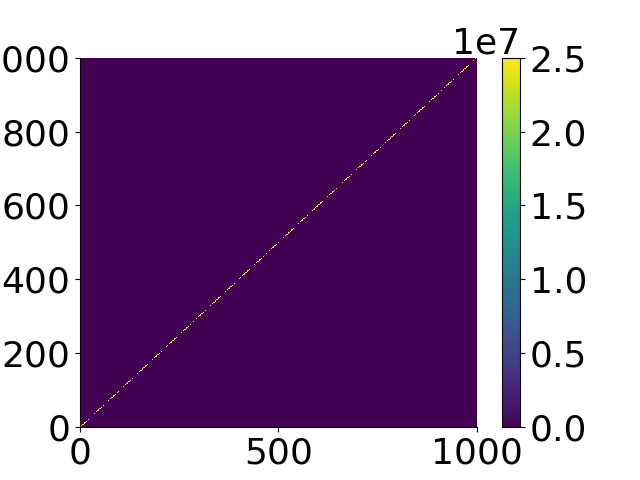

Simulation SPS obtained.
Simulation TPS obtained.
All simulation activity measures completed.
Obtaining analytic predictions...


<IPython.core.display.Javascript object>


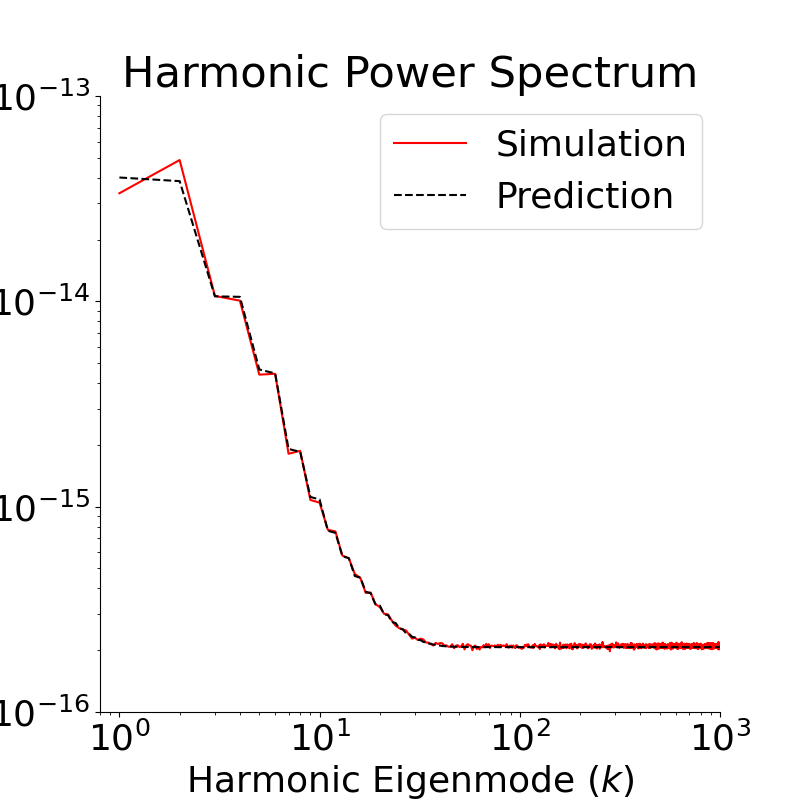

<IPython.core.display.Javascript object>


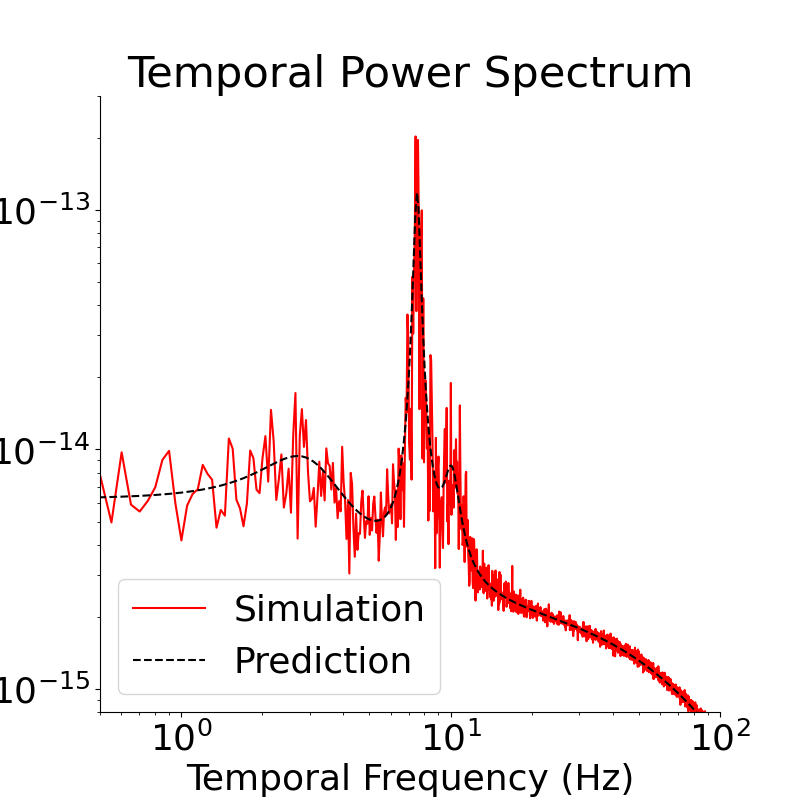

<IPython.core.display.Javascript object>


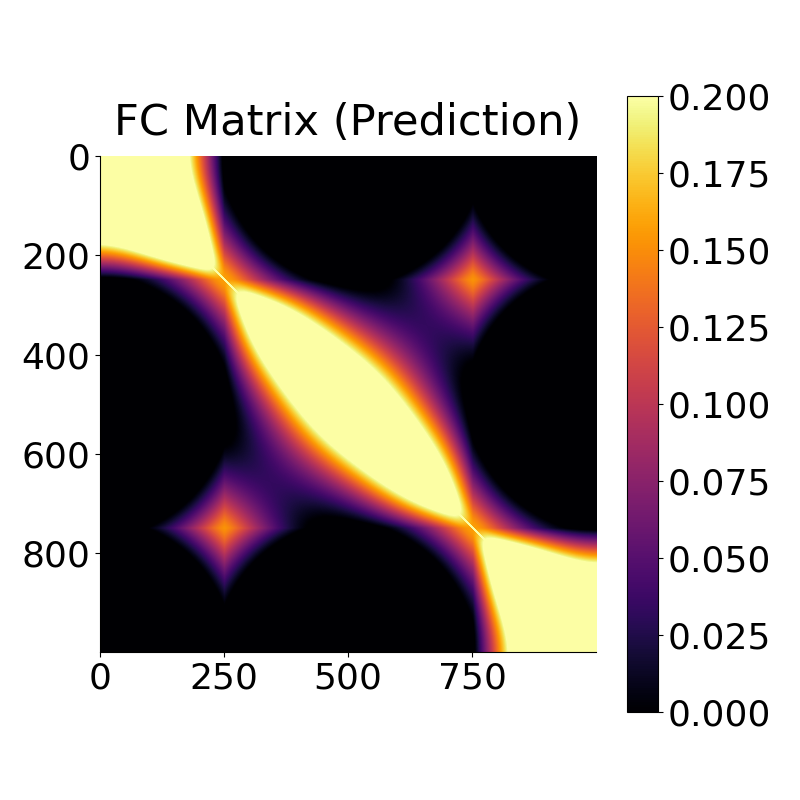

<IPython.core.display.Javascript object>


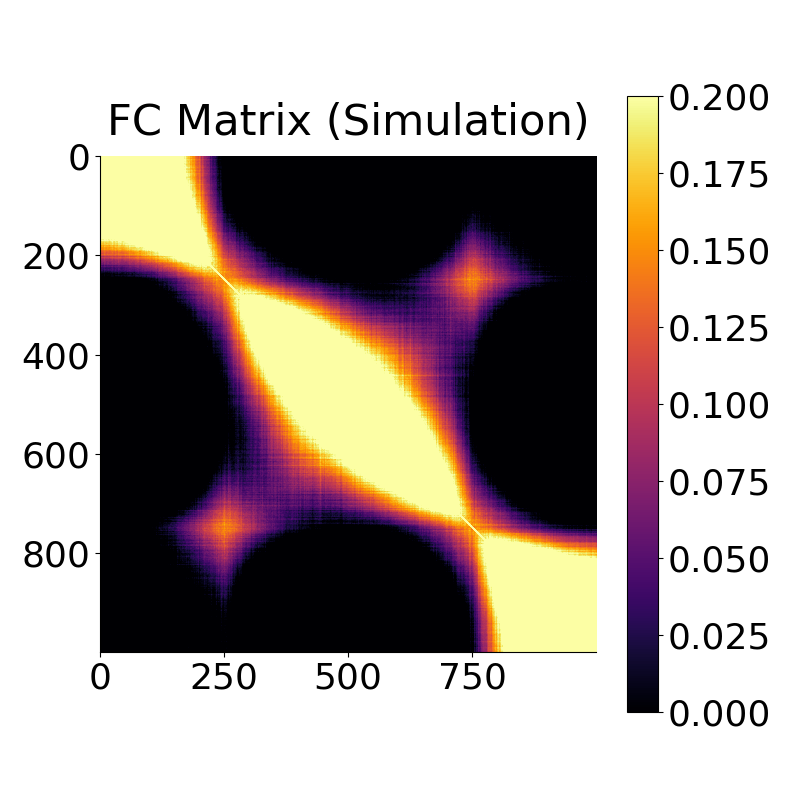

In [24]:
#activity analysis and comparison with prediction
#thesis values
#Max_omega=50
#Delta_omega=0.1

#Min_omega=1*(2*np.pi)
#Max_omega=100*(2*np.pi)
plt.close('all')
#np.save(f"/Volumes/Crucial X8/NFModel_revision_figures/h={h} syn={syn}/activity_1.npy", E_total)

E_total = np.load(f"/Volumes/Crucial X8/NFModel_revision_figures/h={h} syn={syn} s_IE*20/activity_1.npy")

PS, TPS, FC = Activity_Analysis(Ess, Iss, Delta_t, 
                            aEE, aIE, aEI, aII,
                            sEE, sIE, sEI, sII, D,
                            dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,                             
                            E_total=E_total, beta_E_total=None, compute_FC=True,                                                      
                            prediction=True, min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega, temporal_downsampling=1,                       
                            one_dim=True, syn=syn, gridsize=gridsize, h=h,     NSim=1,                      
                            Visual=True, Save_Results=False, Filepath=f"/Volumes/Crucial X8/NFModel_revision_figures/h={h} syn={syn} s_IE*20")
#

In [ ]:
#Human connectome simulation (linearized wilson-cowan: perturbation about steady state)
#thesis time and timestep values
#Time=100
#Delta_t=0.01
#more recent work
Time=2
Delta_t=0.0001

#final (empirical)
Time=100
Delta_t=0.0001

nrSS=0
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]  
SPS_sims=[]
TPS_sims=[]
for sims in range(3):
    Beta_E_total = Linearized_GLDomain_Wilson_Cowan_Model(Ess, Iss, Time, Delta_t,                          
                         aEE, aIE, aEI, aII,
                         sEE, sIE, sEI, sII, D,
                         dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                         one_dim=False, eigvals=eigenvalues, eigvecs=None,
                         Visual=False, SaveActivity=False, Filepath=' ') 

    PS_full, TPS_full = Activity_Analysis(Ess, Iss, Delta_t,
                                   aEE, aIE, aEI, aII,
                                   sEE, sIE, sEI, sII, D,
                                   dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                                
                                   E_total=None, beta_E_total=Beta_E_total, compute_FC=False,
                                   
                                   prediction=True, min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega, temporal_downsampling=100,
                                      
                                 #  Spatial_scaling=[a_spatial,b_spatial], Temporal_scaling=[a_temporal,b_temporal],
                                   
                                   one_dim=False, syn=syn, gridsize=gridsize, h=h,
                                      
                                   eigvals=eigenvalues, eigvecs=None,
                                   
                                   Visual=True, Save_Results=False, Filepath=' ')
    
    SPS_sims.append(PS_full)
    TPS_sims.append(TPS_full)
    np.save('/Volumes/Seagate Expansion Drive/Macbook Stuff/Downloads/NeuralFieldModelv2/Beta_E_total'+str(sims), Beta_E_total)
    del Beta_E_total


In [ ]:
SPS_sims=[]
Time=100
Delta_t=0.0001

nrSS=0
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]  
for sims in range(3):
    Beta_E_total = np.load('/Volumes/Seagate Expansion Drive/Macbook Stuff/Downloads/NeuralFieldModelv2/Beta_E_total'+str(sims)+'.npy')

    PS_full, TPS_full = Activity_Analysis(Ess, Iss, Delta_t,
                                   aEE, aIE, aEI, aII,
                                   sEE, sIE, sEI, sII, D,
                                   dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                                
                                   E_total=None, beta_E_total=Beta_E_total, compute_FC=False,
                                   
                                   prediction=True, min_omega=Min_omega, max_omega=Max_omega, delta_omega=Delta_omega, temporal_downsampling=100,
                                      
                                 #  Spatial_scaling=[a_spatial,b_spatial], Temporal_scaling=[a_temporal,b_temporal],
                                   
                                   one_dim=False, syn=syn, gridsize=gridsize, h=h,
                                      
                                   eigvals=eigenvalues, eigvecs=None,
                                   
                                   Visual=True, Save_Results=False, Filepath=' ')    

    
    SPS_sims.append(PS_full)

    del Beta_E_total    
    
PS_full = np.median(SPS_sims, axis=0)

In [13]:
#np.save('/Volumes/Seagate Expansion Drive/Macbook Stuff/Downloads/NeuralFieldModelv2/simulations_median_PS.npy', PS_full)
#PS_full = np.load('/Volumes/Crucial X8/NFModel_revision_figures/connectome harmonic spectrum/simulations_median_PS.npy')
PS_full = np.load('/Volumes/Crucial X8/NFModel_revision_figures/connectome harmonic spectrum/nonlsim_fix_PS.npy')

<IPython.core.display.Javascript object>


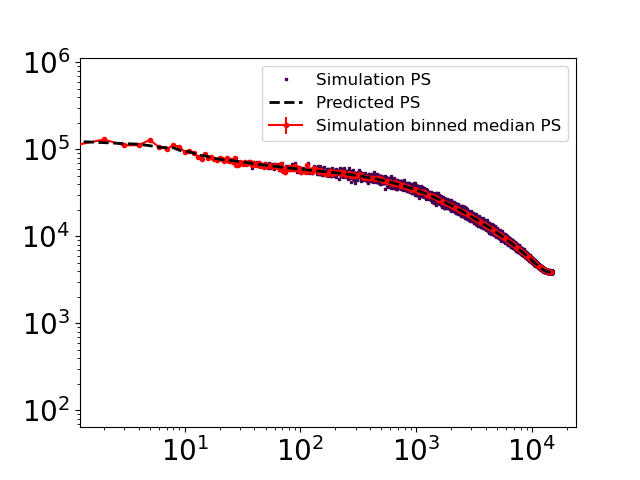

/Users/marcoaqil/anaconda3/envs/prfpy_2021/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/marcoaqil/anaconda3/envs/prfpy_2021/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<IPython.core.display.Javascript object>


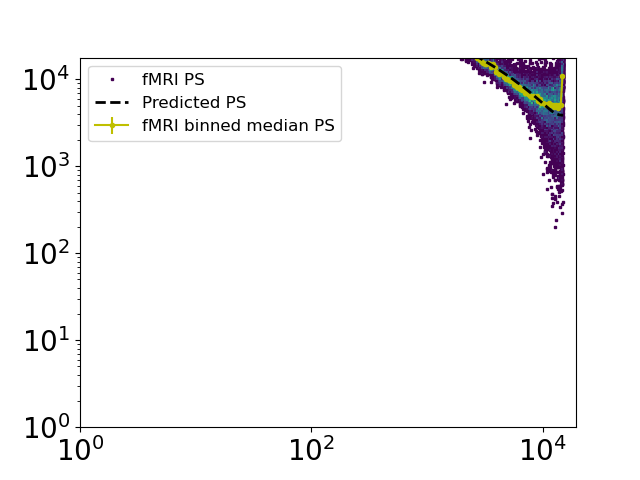

In [14]:
plt.close('all')
plt.ion()
plt.figure()

PS_sims_rescaled = NF_to_empirical(scale_params_spatial,PS_full,0)[first_k:last_k]
analytic_PS_rescaled = NF_to_empirical(scale_params_spatial,Gk_E,Gk_I)[first_k:last_k]

binned_SPS_sim = np.array([np.median(elem) for elem in np.array_split(PS_sims_rescaled, bins)])
binned_SPS_err_sim = np.array([sp.stats.sem(elem) for elem in np.array_split(PS_sims_rescaled, bins)])

plt.loglog(np.arange(first_k, last_k),PS_sims_rescaled, marker='s', linestyle='', markersize=2, zorder=1, color=[0.267004, 0.004874, 0.329415, 1.], label='Simulation PS')
plt.hist2d(np.arange(first_k, last_k),PS_sims_rescaled,(plot_bins, y_bins), cmap='viridis',zorder=2,cmin=2)
plt.loglog(np.arange(first_k, last_k), analytic_PS_rescaled, zorder=4,color='black', linestyle='--', linewidth=2, label = 'Predicted PS')
plt.errorbar(x=binned_SPS_points, y=binned_SPS_sim, yerr=binned_SPS_err_sim, zorder=3, fmt='ro-',markersize=3, label='Simulation binned median PS')
plt.legend(prop={'size': 12})

plt.figure()

plt.loglog(np.arange(first_k, last_k), empirical_SPS, marker='s', linestyle='', markersize=2, zorder=0, color=[0.267004, 0.004874, 0.329415, 1.], label='fMRI PS')
plt.hist2d(np.arange(first_k, last_k), empirical_SPS, (plot_bins, y_bins), cmap='viridis',zorder=1,cmin=2)
plt.loglog(np.arange(first_k, last_k), analytic_PS_rescaled, zorder=3,color='black', linestyle='--', linewidth=2, label = 'Predicted PS')
plt.errorbar(x=binned_SPS_points, y=binned_SPS, yerr=binned_SPS_err, zorder=2, fmt='yo-',markersize=3, label='fMRI binned median PS')
plt.legend(prop={'size': 12})

<IPython.core.display.Javascript object>


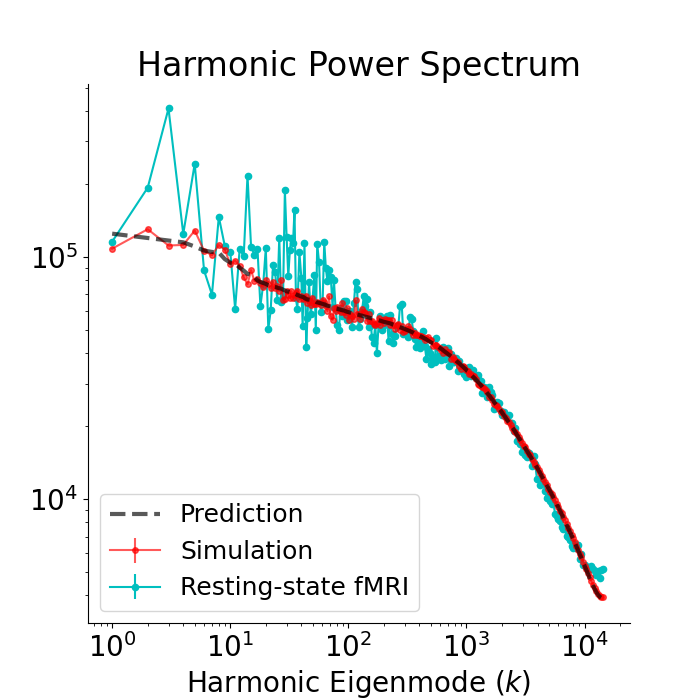

In [16]:
plt.figure(figsize=(7,7))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.loglog(np.arange(first_k, last_k), analytic_PS_rescaled, zorder=2,color='black', linestyle='--', linewidth=3, label = 'Prediction', alpha=0.65)
plt.errorbar(x=binned_SPS_points[:-1], y=binned_SPS_sim[:-1], yerr=0, fmt='ro-',markersize=4, label='Simulation',zorder=1, alpha=0.65)
plt.errorbar(x=binned_SPS_points[:-1], y=binned_SPS[:-1], yerr=0, fmt='co-',markersize=4.5, label='Resting-state fMRI', zorder=0)
plt.xlabel("Harmonic Eigenmode ($k$)")
plt.title("Harmonic Power Spectrum")
plt.legend(prop={'size': 18}, loc=3)
plt.savefig('/Volumes/Crucial X8/NFModel_revision_figures/harmonic_spectra_model_fmri_fix.pdf', dpi=600, bbox_inches='tight')

In [ ]:
#covariance = np.cov(timecourse)
covariance[covariance==0] = 1e-10
covariance[covariance==1] = 1e-10

plt.figure()
plt.pcolormesh(np.dot(np.diag(np.power(np.diag(covariance),-0.5)),np.dot(covariance,np.diag(np.power(np.diag(covariance),-0.5)))),
              vmin=-1,
              vmax=1)

In [ ]:
Func_Conn_prediction = Functional_Connectivity(eigenvectors, NF_to_empirical(scale_params_spatial,Gk_E,Gk_I), one_dim=False, Visual=True)

In [ ]:
##########################################################################################################
0.0001 10 slightly too high (time interval not small enough)
0.00008 8 slightly too high (time interval not small enough?)
0.00005 10 not doable
0.00005 7 slightly too low
0.00005 5 slightly too low (duration too short?)
0.00001 1 white noise like (low) (duration too short)

In [ ]:
#further verification: 1D grid simulation (linearized wilson-cowan: perturbation about steady state)

#duration and timestep
Time=3
Delta_t=0.00001

#parameters of 1D graph (nonlocal synapses, grid size, grid spacing)
syn=150
gridsize=1000
h=1

nrSS=0
Ess = steady_states[0,nrSS]
Iss = steady_states[1,nrSS]   



Beta_E_total_1D = Linearized_GLDomain_Wilson_Cowan_Model(Ess, Iss, Time, Delta_t,                          
                         aEE, aIE, aEI, aII,
                         sEE, sIE, sEI, sII, D,
                         dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                         one_dim=True, syn=syn, gridsize=gridsize, h=h,
                         eigvals=None, eigvecs=None,
                         Visual=False, SaveActivity=False, Filepath=' ') 



In [ ]:
#activity analysis of linearized model and comparison with prediction (perturbation about steady state)
#thesis values
#Max_omega=50
#Delta_omega=0.1
plt.close('all')
Max_omega=3000
Delta_omega=0.5

PS_full_1D, TPS_full_1D = Activity_Analysis(Ess, Iss, Delta_t,
                                   aEE, aIE, aEI, aII,
                                   sEE, sIE, sEI, sII, D,
                                   dE, dI, P, Q, tE, tI, snE, snI, Graph_Kernel,
                                
                                   beta=True, beta_E_total=Beta_E_total_1D,
                                   
                                   prediction=True, max_omega=Max_omega, delta_omega=Delta_omega,
                                   
                                   one_dim=True, syn=syn, gridsize=gridsize, h=h,
                                      
                                   eigvals=None, eigvecs=None,
                                   
                                   Visual=True, Save_Results=False, Filepath=' ')


In [ ]:
#MISC
#Beta_E_total=np.load('G:/Macbook Stuff/Simulation Results/Decent spatiotemporal spectrum activity.npy')
#del Beta_E_total
#del eigenvectors
#del connectome_activity
#np.save('G:/Macbook Stuff/Simulation Results/Decent spatiotemporal spectrum activity.npy', Beta_E_total)
#print(len(Beta_E_total[0]))
#print(Beta_E_total[0])
with h5py.File("G:/Macbook Stuff/Simulation Results/Decent spatiotemporal spectrum activity.h5") as hf:
    if "Activity" not in list(hf.keys()):
        #connectome_activity=np.dot(eigenvectors,Beta_E_total)
        hf.create_dataset("Activity",  data=connectome_activity)
    else:
        print("Warning: overwriting results of a previous simulation.") 

In [ ]:
#################******** PROPAGATOR TESTS ********#################

In [ ]:
#propagator test 1
#damped wave/telegrapher parameters
#params for first working tests: a=0.3, b=0.001, c=0, Delta_t=1, h=1 (worked with 2-normalized eigenvalues)
#make a smaller: wave travels faster
a=0.3
#make b larger: more diffusion
b=0.001
#nonzero c: switch from damped wave to telegrapher eqn
c=0

gridsize=1000
syn=0
h=1
u_0=0.3*sp.signal.gaussian(gridsize, 10)#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=1
Time=100
#u_0[499]=1
u_final=graph_propagator_test(u_0, Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Damped Wave', a=a, b=b, c=c, sigma_noise=0.0,
                          one_dim=True, syn=syn, gridsize=gridsize,  h=h, eigvals=None, eigvecs=None,                         
                          Visual=True, SaveActivity=False, Filepath=' ', NSim=0)

In [ ]:
#propagator test 2
gridsize=1000
syn=0
h=1
u_0=np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=1
Time=Delta_t
u_0[499]=400
#u_0=np.ones(gridsize)
u_final=graph_propagator_test(u_0, Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Gaussian', sigma_noise=0,
                          one_dim=True, syn=syn, gridsize=gridsize,  h=h, eigvals=None, eigvecs=None,                         
                          Visual=True, SaveActivity=False, Filepath=' ', NSim=0)
np.sum(u_final)

In [ ]:
#proptest 3 cortical mesh convolutions

u_0=np.zeros(len(eigenvalues))#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
u_0[6369]=50
u_prop=graph_propagator_test(u_0, Time=50, Delta_t=50, kernel_param=50/1000000, Graph_Kernel='Gaussian', sigma_noise=0.0,
                          one_dim=False, syn=0, gridsize=0,  h=0, eigvals=eigenvalues, eigvecs=eigenvectors,                         
                          Visual=False, SaveActivity=False, Filepath=' ', NSim=0)

In [ ]:
#propagator test 4: cortical mesh
##NOTE: THESE PARAMETERS WERE FOR THE EIGENVALUES OF THE LAPLACIAN IN MILLIMIETERS
#damped wave/telegrapher parameters
#params for first working tests: a=0.3, b=0.001, c=0, Delta_t=1
#params for wave first figure: a=0.3 b=0.005 c=0 (*1000000) (faster wave: a=0.15 b=0.0025)
#make a smaller: wave travels faster
a=0.3
#make b larger: more diffusion
b=0.005
#nonzero c: switch from damped wave to telegrapher eqn
c=0

#in metres it should be enough to do (also change initial gaussian kernel param)
a*=1000000
b*=1000000


u_0=np.zeros(len(eigenvalues))#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=1
Time=60
u_0[6369]=50

#gauss kernel parm 50/1000000


u_1=graph_propagator_test(np.dot(eigenvectors.T,u_0), Time=2, Delta_t=1, kernel_param=50/1000000, 
                          Graph_Kernel='Gaussian', sigma_noise=0.0,
                          one_dim=False, syn=0, gridsize=0,  h=0, eigvals=eigenvalues, GF_domain=True,                         
                          Visual=False, SaveActivity=False, Filepath=' ', NSim=0)
u_total=graph_propagator_test(u_1[:,1], Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Damped Wave', a=a, b=b, c=c, sigma_noise=0.0,
                          one_dim=False, syn=0, gridsize=0,  h=0, eigvals=eigenvalues, GF_domain=True,                       
                          Visual=False, SaveActivity=False, Filepath=' ', NSim=0)
u_total=np.dot(eigenvectors,u_total)

In [ ]:
resamp_conn_activity = np.dot(eigenvectors.T, np.load('/Volumes/Seagate Expansion Drive/Macbook Stuff/Downloads/NeuralFieldModelv2/Beta_E_total0.npy')[:,::7200])

In [ ]:
#propagator test 5 stochastic damped wave in fourier domain for quantitative spectrum calculation

#make a smaller: wave travels faster
#make b larger: more diffusion

#nonzero c: switch from damped wave to telegrapher eqn
c=0


a=0.3*1000000
b=0.05*1000000
sigma_noise=0.0001


beta_0=np.ones(len(eigenvalues))#np.zeros(gridsize)#(-0.1/499**2)*(np.arange(gridsize)-499)**2 + 0.1 
Delta_t=1
Time=200

dw_beta_act=graph_propagator_test(np.dot(eigenvectors.T, beta_0), Time, Delta_t, kernel_param=Delta_t, Graph_Kernel='Damped Wave', a=a, b=b, c=c,
                                 sigma_noise=sigma_noise,
                                 one_dim=False, syn=0, gridsize=0,  h=0, GF_domain=True, eigvals=eigenvalues,                          
                                 Visual=False, SaveActivity=False, Filepath=' ', NSim=0)


#dw_PS_pred

In [ ]:
#dw_beta_act = np.load('G:\Macbook Stuff\Simulation Results\Damped Wave Kernel Test t=1\0# Sim Activity.h5')
dw_PS = np.var(dw_beta_act, axis=1)
dw_TPS = sp.signal.periodogram(dw_beta_act, fs=1/Delta_t, detrend='constant', scaling='density')
f = plt.figure()
plt.plot(dw_PS)
f2 = plt.figure()
plt.plot(dw_TPS[0]*(2*np.pi),np.sum(dw_TPS[1], axis=0))

In [ ]:
a=10000
b=50000000
sigma_noise=0.001

lambdas, omegas = np.meshgrid(eigenvalues, dw_TPS[0][1:]*(2*np.pi))
prediction = sigma_noise**2 / (b**2 * omegas**2 + (lambdas - a*omegas**2)**2)

#f3 = plt.figure()
#ax = f3.add_subplot(111)
#pc = ax.pcolormesh(lambdas, omegas, prediction)
#f3.colorbar(pc)

f4 = plt.figure()
plt.plot(dw_TPS[0][1]*np.sum(prediction, axis=0)/np.pi)
f5 = plt.figure()
plt.plot(dw_TPS[0][1:]*(2*np.pi), 2*np.sum(prediction, axis=1))


In [ ]:
import plotly.offline as offline
from plotly.graph_objs import *
import plotly.graph_objs as go
#init_notebook_mode(connected=True)
offline.init_notebook_mode()
f = h5py.File('/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/100307_Laplace.mat', 'r')
CC = np.asarray(f['CC']['restInds'], dtype=int)
indices = np.array([elem[0] for elem in CC])-1
AllVet=np.asarray(f['vertices']['all'])
AllVet=AllVet[:,indices]

dist=np.sqrt(AllVet[0,:]**2 + AllVet[1,:]**2 + AllVet[2,:]**2)

trace1=go.Scatter3d(x=Xe,
              y=Ye,
              z=Ze,
              mode='lines',
             line=Line(color='rgba(0,0,0,1)', width=1),
            )

trace2=Mesh3d(x=Xn,
               y=Yn,
               z=Zn,
              i=iN,
              j=jN,
              k=kN,
              text=np.arange(len(Xn)),
             color='rgba(0.5, 0, 0, 1)',
             lighting = dict(ambient=1, diffuse=0.1, roughness = 0.9, specular=1.8, fresnel=0.01)
                )

trace4 = go.Scatter3d(
    x=AllVet[0,:],
    y=AllVet[1,:],
    z=AllVet[2,:],
    #alphahull=50
    mode='markers',
    marker=dict(
        size=5,
        color=dist,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=1,
        #line=dict(color='rgba(0, 0, 0,0.5)',width=1,)
        )
    )

data = [trace1,trace2,trace4]
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )
                 
layout = Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
    hovermode=False,
        width=1000,
    height=700
)    
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig)

In [5]:
new_Fibers = np.load('/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/Fibers_myfix.npy',allow_pickle=True)

fiber_edges=np.load('/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/fgCCfix_fiber_edges.npy')
f = h5py.File('/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/100307_Laplace.mat', 'r')
CC = np.asarray(f['CC']['restInds'], dtype=int)
f.close()
indices = np.array([elem[0] for elem in CC])-1
EX=[]
EY=[]
EZ=[]
colors=[]

counter=0
#use different last value to not plot all fibers (less intensive for viz)
for i in range(1,len(new_Fibers),2):
    if fiber_edges[i,0] in indices and fiber_edges[i,1] in indices and fiber_edges[i,0]!=fiber_edges[i,1]:
        counter+=1
        for j in range(new_Fibers[i].shape[0]-1):
            EX+=[new_Fibers[i][j,0], new_Fibers[i][j+1,0], None]
            EY+=[new_Fibers[i][j,1], new_Fibers[i][j+1,1], None]
            EZ+=[new_Fibers[i][j,2], new_Fibers[i][j+1,2], None]

print(counter)    


#fig_frames.write_image("G:/fig1.png")    

6668


In [ ]:
import plotly.offline as offline
import plotly.graph_objs as go
from plotly.graph_objs import *
offline.init_notebook_mode()

trace3=go.Scatter3d(x=EX,
               y=EY,
               z=EZ,
               mode='lines',
               line=Line(color=[p if p is not None else 0 for p in EX],#EX,#'rgba(100,100,100,0.9)',#colors
                         colorscale=[(0,"red"),(0.5,"white"),(1,"green")],#colorscale=[[0, 'rgb(0,0,255)'], [1, 'rgb(255,0,0)']],#'Rainbow',
                         width=1),
               )
axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )
                 
layout = Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        ),
    hovermode=False,
        width=1000,
    height=700
)       
data=[trace3]
fig=Figure(data=data, layout=layout)

offline.iplot(fig, filename='Les-Miserables-2')

In [ ]:
import plotly.offline as offline
from plotly.graph_objs import *
#init_notebook_mode(connected=True)
offline.init_notebook_mode()

with h5py.File('/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/Simulation Results/Damped Wave Kernel Test t=1/0# Sim Activity nice wave b=0.002.h5', 'r') as file:
    print(list(file.keys()))
    DWave = np.asarray(file['Activity'], dtype=float)

###SET WHAT IS GONNA BE PLOTTED
interval = 5
start_time = 0
max_time = 150#11* interval

#timecourse_demeaned = timecourse-timecourse.mean(1)[...,np.newaxis]
#np.sqrt(3.85007284e+18)*resamp_conn_activity[:,i]
#np.nan_to_num(sp.stats.zscore(timecourse, axis=1))[:,i]
#np.nan_to_num(sp.stats.zscore(resamp_conn_activity, axis=1))[:,i]
frames =[dict(data=[dict(type='scatter3d', 
                         #HERE IS WHAT DECIDES THE COLOR-TIMEPLOT
                         mode='markers',
                        marker=dict(
                        size=5,
                        color=DWave[:,i],                # set color to an array/list of desired values
                        colorscale='RdBu_r',   # choose a colorscale
                        opacity=1,
                        cmin=-0.01,
                        cmax=0.01
                        ))],#u_total[:,i])],#eigenvectors[:,i]#timecourse_demeaned[:,i]
                  traces=[1],
                  name='{}'.format(i)) for i in range(start_time,max_time,interval)] 



axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )
                 
layout = Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
            #good left occipital love view eye=dict(x=-1, y=-1.25, z=0.9). view from top eye=dict(x=0, y=0, z=1.8)
    eye=dict(x=0, y=0, z=1.8)
)),  
    hovermode=False,     autosize=False,
    width=1000,
    height=700
)       
#trace2 is the mesh
data=[trace1,trace4] #trace1 trace2

fig_frames = Figure(data=data, layout=layout, frames=frames)

fig_frames['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 120, 'redraw': True},
                         'fromcurrent': True, 'transition': {'duration': 120, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate',
                'transition': {'duration': 0}}], 
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': True,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]



fig_frames['layout']['sliders'] = [{
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'time=',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 120, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 5},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': [{
    'method': 'animate',
    'label': '{}'.format(i),
   # 'value': '',
    'args': [[i], {'frame': {'duration': 300, 'redraw': True},
         'mode': 'immediate'}
    ],
} for i in range(start_time,max_time,interval)]
}]



offline.iplot(fig_frames, filename='Les-Miserables')

In [ ]:
print(AllVet[0,:].max())
print(np.max([p if p is not None else 0 for p in EX]))
print(AllVet[1,:].max())
print(np.max([p if p is not None else 0 for p in EY]))
print(AllVet[2,:].max())
print(np.max([p if p is not None else 0 for p in EZ]))

In [ ]:
print(AllVet[0,:].min())
print(np.min([p if p is not None else 0 for p in EX]))
print(AllVet[1,:].min())
print(np.min([p if p is not None else 0 for p in EY]))
print(AllVet[2,:].min())
print(np.min([p if p is not None else 0 for p in EZ]))

In [ ]:
np.save('/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/Fibers_myfix.npy', new_Fibers)

In [14]:
# with h5py.File('/Volumes/Crucial X8/NFModel_revision_figures/NeuralFieldModelV3/Fibers_myfix.mat', 'r') as file:
#     print(list(file.keys()))    
#     print(list(file['fgCC'].keys()))
            
#     Fibers=[file[element][:] for element in file['fgCC']['fibers'][0]]

#ftrp = [  0.64060797, -17.36580411,  13.03890559,  -0.13529114,  -0.05266986,
#  -0.15545509]# res['x']
#dist 41747080018.28796
#ftrp = [ -1.39994323, -17.59341562,  13.10134819,  -0.13566532,  -0.04219775,
#  -0.07388072]
#dist 41746948797.46434
ftrp = [ -1.39684783, -17.59248972,  13.10377312,  -0.13559833,  -0.04221072,
  -0.07400676]
#41746948747.51729
new_Fibers = []

from numpy import cross, eye, dot
from scipy.linalg import expm, norm

def M(axis, theta):
    return expm(cross(eye(3), axis/norm(axis)*theta))

for i in range(len(Fibers)):
    Fibers[i][:,0] += ftrp[0]
    Fibers[i][:,1] += ftrp[1]
    Fibers[i][:,2] += ftrp[2]
    
    v, axis, theta = Fibers[i].T, [1,0,0], ftrp[3]
    M0 = M(axis, theta)
    rot_v = dot(M0,v)

    v, axis, theta = rot_v, [0,1,0], ftrp[4]
    M0 = M(axis, theta)
    rot_v = dot(M0,v)

    v, axis, theta = rot_v, [0,0,1], ftrp[5]
    M0 = M(axis, theta)
    rot_v = dot(M0,v)
    
    new_Fibers.append(rot_v.T)

['#refs#', 'fg', 'fgCC', 'options', 'trackOpts']
['colorRgb', 'coordspace', 'fibers', 'name', 'params', 'query_id', 'seedRadius', 'seedVoxelOffsets', 'seeds', 'thickness', 'visible']


In [ ]:
#beta_u_total=np.load('G:/Macbook Stuff/Simulation Results/new realistic activity.npy')#np.dot(eigenvectors, dw_beta_act)
#u_total=np.dot(eigenvectors,beta_u_total)
#del beta_u_total
#del eigenvectors
#covariance = np.cov(u_total)
#del u_total
#FC=np.dot(np.diag(np.power(np.diag(covariance),-0.5)),np.dot(covariance,np.diag(np.power(np.diag(covariance),-0.5))))    
#del covariance

# plt.close('all')
# fig=plt.figure()
# ax = fig.add_subplot(111)
# im = ax.imshow(FC, vmax=0.1, vmin=-0.1)
# fig.colorbar(im)

In [ ]:
#np.save('G:/Macbook Stuff/Simulation Results/FC new realistic', FC)
#np.save('G:/Macbook Stuff/Simulation Results/new realistic activity', u_total)

In [ ]:
import plotly.offline as offline
from plotly.graph_objs import *
#init_notebook_mode(connected=True)
offline.init_notebook_mode()

#mesh (or full connectome) graph edges
#trace1=Scatter3d(x=Xe,
#               y=Ye,
#               z=Ze,
#               mode='lines',
#              line=Line(color='rgba(0,0,0,1)', width=1),
#             )

#Mesh3d
trace2=Mesh3d(x=Xn,
               y=Yn,
               z=Zn,
              i=iN,
              j=jN,
              k=kN,
              text=np.arange(len(Xn)),
              #lighting used for NFModel plots, not for DWave
             lighting = dict(ambient=1, diffuse=0.1, roughness = 0.9, specular=1.8, fresnel=0.01),
              #colorlimits USE IF NEEDED (0.1 good for Dwave, 0.01 to show WMprop)(20 good for fmri demeaned)
              cmin=-20,#-10E-9,#-0.1,#-10E-9,#-0.1,
              cmax=20, #10E-9#0.1#10E-9#0.1
              #eigenvectors[:,1001]#
              
            
              
          #     mode='markers',
          #  marker=dict(
          #          size=5,
          #          color=-AllVet[1,:],#np.sqrt(AllVet[2,:]**2+AllVet[0,:]**2+AllVet[1,:]**2),                # set color to an array/list of desired values
                    colorscale='RdBu_r',   # choose a colorscale
          #          opacity=0.8,
          #          line=dict(color='rgba(0, 0, 0,0.5)',
          #                     width=1,
        #                     )
        #                )
                )


###SET WHAT IS GONNA BE PLOTTED
interval = 1
start_time = 50
max_time = 55#11* interval

#timecourse_demeaned = timecourse-timecourse.mean(1)[...,np.newaxis]
#np.sqrt(3.85007284e+18)*resamp_conn_activity[:,i]
#np.nan_to_num(sp.stats.zscore(timecourse, axis=1))[:,i]
#np.nan_to_num(sp.stats.zscore(resamp_conn_activity, axis=1))[:,i]
frames =[dict(data=[dict(type='mesh3d', 
                         #HERE IS WHAT DECIDES THE COLOR-TIMEPLOT
                         intensity= timecourse_demeaned[:,i])],#u_total[:,i])],#eigenvectors[:,i]
                  traces=[0],
                  name='{}'.format(i)) for i in range(start_time,max_time,interval)] 



axis=dict(showbackground=False,
          showline=False,
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title=''
          )
                 
layout = Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    scene=dict(
             xaxis=dict(axis),
             yaxis=dict(axis),
             zaxis=dict(axis),
        camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
            #good left occipital love view eye=dict(x=-1, y=-1.25, z=0.9). view from top eye=dict(x=0, y=0, z=1.8)
    eye=dict(x=0, y=0, z=1.8)
)),  
    hovermode=False,     autosize=False,
    width=1000,
    height=1150
)       
data=[trace2]

fig_frames = Figure(data=data, layout=layout, frames=frames)

fig_frames['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 120, 'redraw': True},
                         'fromcurrent': True, 'transition': {'duration': 120, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate',
                'transition': {'duration': 0}}], 
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': True,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]



fig_frames['layout']['sliders'] = [{
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'time=',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 120, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 5},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': [{
    'method': 'animate',
    'label': '{}'.format(i),
   # 'value': '',
    'args': [[i], {'frame': {'duration': 300, 'redraw': True},
         'mode': 'immediate'}
    ],
} for i in range(start_time,max_time,interval)]
}]



#fig=Figure(data=data, layout=layout)

offline.iplot(fig_frames, filename='Les-Miserables')